# One Model, Two Voices: Adaptive AI for Diverse Needs
**Scenario**: A tech company with 300 engineers and 40 marketing staff  seeks to enhance document search and question answering (QA) capabilities for these teams. They're also exploring the integration of Generative AI (GenAI) products within their product release cycle (quarterly).

**Goal**: This mini-Proof of Concept (POC) aims to evaluate the potential of Retrieval-Augmented Generation (RAG) for improving document search and question answering.

**Tasks**
- Implement a RAG system using LangChain.
- Develop metrics to assess the system's ability to replicate provided "gold standard" responses (labeled data) for marketing and engineering questions.
- Experiment with various hyper-parameters and settings to optimize performance based on the chosen metrics.
- Prepare a comprehensive evaluation report, including identified risks and limitations.

**Data**: A gold dataset containing high-quality responses to questions from marketing and engineering teams is provided.

## Setup

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip -q install transformers
!pip -q install datasets loralib sentencepiece
!pip -q install bitsandbytes accelerate
!pip -q install langchain
!pip install faiss-gpu
!pip install --upgrade --quiet  langchain-community chromadb bs4 qdrant-client
!pip install langchainhub
!pip install --upgrade --quiet  wikipedia
!pip install --upgrade --quiet  arxiv
!pip install --upgrade --quiet  pymupdf
!pip install xmltodict
!pip install sentence_transformers
!pip install evaluate
!pip install git+https://github.com/google-research/bleurt.git
!pip install bert_score
!pip install langchain_cohere
!pip install optuna

In [ ]:
# Standard library imports
import copy
import os
import json
import time
import re
import locale
from typing import Tuple, List, Dict, Any
from pprint import pprint
from itertools import product
import logging
import warnings
import gc

# Third-party imports
import torch
import numpy as np
import pandas as pd
import bs4
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig, EvalPrediction
import evaluate
from google.colab import userdata
import optuna
import pickle

# LangChain imports
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader, TextLoader, ArxivLoader, WikipediaLoader, PyMuPDFLoader
from langchain_community.vectorstores import Qdrant
from langchain_core.runnables import RunnablePassthrough
from langchain_community.utils.math import cosine_similarity

# Cohere-specific imports
from langchain_cohere.llms import Cohere

In [ ]:
# Global variable
PATH_TO_WORKING_DIR = "/content/drive/MyDrive/Schoolwork/W290/2024-spring-assignment-garyukong/assignment/a5/"  # Working directory on mounted gDrive

# Change the current working directory
os.chdir(PATH_TO_WORKING_DIR)

# Set paths
RESULTS_DF_PATH = "data/interim/results_df.pkl"
OPTUNA_STUDIES_FOLDER_PATH = "data/interim/optuna_studies/"

In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
COHERE_API_KEY = userdata.get("COHERE_API_KEY")

In [ ]:
# Configure logging to write to a file, with the desired format and level
logging.basicConfig(
    filename="data/interim/warnings.log",
    filemode="w",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.WARNING,
)

# Show only warnings and above
logging.getLogger("transformers").setLevel(logging.WARNING)


# Function to log warnings
def warn_with_log(message, category, filename, lineno, file=None, line=None):
    logging.warning(f"{filename}:{lineno}: {category.__name__}: {message}")


# Redirect warnings to the logging system
warnings.showwarning = warn_with_log

## Test Data

In [6]:
PATH_TO_DATA = '../data/raw/validation_data.json'

# Load the data
with open(PATH_TO_DATA, 'r') as f:
    validation_questions_answers = json.load(f)

In [ ]:
# @title Analyse distribution of word lengths in gold standard research and marketing responses
def analyze_answer_word_lengths(validation_questions_answers, tokenizer, cohere_tokens_per_word=3):
    """
    Analyzes the token and word lengths of research and marketing answers.

    Args:
        validation_questions_answers (dict):  A dictionary containing "gold_answer_research"
                                              and "gold_answer_marketing" keys.

    Returns:
        tuple: A tuple containing DataFrames with summary statistics for research and marketing answers.
    """

    def calculate_word_lengths(answers):
        """Calculates the number of words in a list of strings."""
        return [len(answer.split()) for answer in answers]

    def calculate_token_lengths(answers):
        """Calculates the number of tokens in a list of strings."""
        return [len(tokenizer(answer)["input_ids"]) for answer in answers]

    # Extract answers
    questions = [item["question"] for item in validation_questions_answers.values()]
    research_answers = [item["gold_answer_research"] for item in validation_questions_answers.values()]
    marketing_answers = [item["gold_answer_marketing"] for item in validation_questions_answers.values()]

    # Calculate lengths
    questions_word_lengths = calculate_word_lengths(questions)
    research_word_lengths = calculate_word_lengths(research_answers)
    marketing_word_lengths = calculate_word_lengths(marketing_answers)
    question_token_lengths = calculate_token_lengths(questions)
    research_token_lengths = calculate_token_lengths(research_answers)
    marketing_token_lengths = calculate_token_lengths(marketing_answers)

    # Calculate statistics and create DataFrames
    stats_data = {
        "Research Word Lengths": pd.Series(research_word_lengths).describe(),
        "Marketing Word Lengths": pd.Series(marketing_word_lengths).describe(),
        "Research Mistral Token Lengths": pd.Series(research_token_lengths).describe(),
        "Marketing Mistral Token Lengths": pd.Series(marketing_token_lengths).describe(),
    }
    stats_df = pd.DataFrame(stats_data)

    stats_df["Research Cohere Est Token Lengths"] = stats_df["Research Word Lengths"] * cohere_tokens_per_word
    stats_df["Marketing Cohere Est Token Lengths"] = stats_df["Marketing Word Lengths"] * cohere_tokens_per_word

    return stats_df


# analyze_answer_word_lengths(validation_questions_answers, llm_mistral_tokenizer)

In [ ]:
# @title Prepare Data for Evaluation
def prepare_evaluation_data(validation_questions_answers, subset_size=10):
    """
    Prepares evaluation data from the validation questions and answers.

    Parameters:
    - validation_questions_answers: dict, a dictionary containing the validation dataset.
    - subset_size: int or None, the number of items to include in the subset. If None, the full dataset is used.

    Returns:
    - A tuple of lists: (X, y_research, y_marketing, X_subset, y_research_subset, y_marketing_subset)
    """
    X = []
    y_research = []
    y_marketing = []

    for item in validation_questions_answers.values():
        X.append(item["question"])
        y_research.append(item["gold_answer_research"])
        y_marketing.append(item["gold_answer_marketing"])

    if subset_size is not None and subset_size > 0:
        X_subset = X[:subset_size]
        y_research_subset = y_research[:subset_size]
        y_marketing_subset = y_marketing[:subset_size]
    else:
        X_subset = X
        y_research_subset = y_research
        y_marketing_subset = y_marketing

    print(f"X Shape: {len(np.array(X))}")
    print(f"y_research Shape: {len(np.array(y_research))}")
    print(f"y_marketing Shape: {len(np.array(y_marketing))}")
    print(f"X_subset Shape: {len(np.array(X_subset))}")
    print(f"y_research_subset Shape: {len(np.array(y_research_subset))}")
    print(f"y_marketing_subset Shape: {len(np.array(y_marketing_subset))}")

    return X, y_research, y_marketing, X_subset, y_research_subset, y_marketing_subset

X_full, y_research_full, y_marketing_full, X_subset, y_research_subset, y_marketing_subset = prepare_evaluation_data(
    validation_questions_answers
)

X Shape: 75
y_research Shape: 75
y_marketing Shape: 75
X_subset Shape: 10
y_research_subset Shape: 10
y_marketing_subset Shape: 10


## Running the RAG System

Let's now use the data to ask questions against it. So we need to define our prompt templates, the RAG Chain, etc.

We have two types of User Personas we need to support:

1. The engineers, who require pretty detailed information when they ask questions  
2. The marketing team and supporting staff who also will ask questions around GenAI in order to better understand the products and the field as a whole, but a lot more high level answers would likely be in order

We will follow the following structure for developing the RAG pipeline:

1. Set up retrieval system (e.g., a vector store with a comprehensive index)
2. Design prompt templates for both personas.
3. Set up the language models (Cohere, Mistral).
4. Build the RAG chains, integrating the retriever, prompt templates, and language model (varying this by user persona)

#### Step 1: Setup the retrieval system

**Objective**: Establish a vector store (also known as a vector database or embedding index) that the retrieval system will use to fetch relevant information. The index should be populated with embeddings of the data points (e.g., documents, passages, or any other form of information relevant to the application) that the RAG system will retrieve.

In [ ]:
DEFAULT_RETRIEVAL_PARAMS = {
    "base_embedding_model": "multi-qa-mpnet-base-dot-v1",
    "chunk_size": 128,
    "chunk_overlap": 0,
    "search_type": "similarity",
    "search_kwargs": {"k": 5},
}


class RetrievalSystem:
    def __init__(
        self,
        base_embedding_model=DEFAULT_RETRIEVAL_PARAMS["base_embedding_model"],
        chunk_size=DEFAULT_RETRIEVAL_PARAMS["chunk_size"],
        chunk_overlap=DEFAULT_RETRIEVAL_PARAMS["chunk_overlap"],
        search_type=DEFAULT_RETRIEVAL_PARAMS["search_type"],
        search_kwargs=DEFAULT_RETRIEVAL_PARAMS["search_kwargs"],
    ):
        """
        Initialize the retrieval system.

        Args:
            base_embedding_model (str): The name of the base embedding model to use.
            chunk_size (int): The size of the chunks to split the documents into.
            chunk_overlap (int): The overlap between chunks.
        """
        assert base_embedding_model in [
            "all-MiniLM-L6-v2",
            "multi-qa-mpnet-base-dot-v1",
            "avsolatorio/GIST-Embedding-v0",
        ], "Invalid base embedding model. Please choose one of the following: all-MiniLM-L6-v2, multi-qa-mpnet-base-dot-v1, avsolatorio/GIST-Embedding-v0"
        print(f"Setting up retrieval system...")
        self.base_embedding_model = base_embedding_model
        self.base_embeddings = HuggingFaceEmbeddings(model_name=base_embedding_model)

        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size, chunk_overlap=self.chunk_overlap
        )

        self.search_type = search_type
        self.search_kwargs = search_kwargs

        self.qdrant_vectorstore = None
        self.retriever = None

        self.global_doc_number = 1
        self.all_arxiv_pages = []
        self.all_wiki_docs = []
        self.all_web_docs = []
        self.all_arxiv_splits = []
        self.all_wiki_splits = []
        self.all_web_splits = []
        self.all_splits = []

        self.arxiv_ids = [
            "2005.11401",
            "2104.07567",
            "2104.09864",
            "2105.03011",
            "2106.09685",
            "2203.02155",
            "2211.09260",
            "2211.12561",
            "2212.09741",
            "2305.14314",
            "2305.18290",
            "2306.15595",
            "2309.08872",
            "2309.15217",
            "2310.06825",
            "2310.11511",
            "2311.08377",
            "2312.05708",
            "2401.06532",
            "2402.01306",
        ]
        self.wiki_queries = ["Generative Artificial Intelligence", "Information Retrieval", "Large Language Models"]
        self.load_max_docs_per_wiki_query = 4
        self.web_paths = [
            "https://lilianweng.github.io/posts/2020-10-29-odqa/",
            "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
            "https://lilianweng.github.io/posts/2018-06-24-attention/",
        ]

        self.load_all_documents()
        self.split_and_reindex()
        print(f"Retrieval system set up")

    def get_params(self):
        """
        Get the parameters for the retrieval system.

        Returns:
            base_embedding_model (str): The name of the base embedding model to use.
            chunk_size (int): The size of the chunks to split the documents into.
            chunk_overlap (int): The overlap between chunks.
        """
        return {
            "base_embedding_model": self.base_embedding_model,
            "chunk_size": self.chunk_size,
            "chunk_overlap": self.chunk_overlap,
        }

    def update_chunk_params(
        self, chunk_size=DEFAULT_RETRIEVAL_PARAMS["chunk_size"], chunk_overlap=DEFAULT_RETRIEVAL_PARAMS["chunk_overlap"]
    ):
        """
        Set parameters for the retrieval system and reindex the documents.

        Args:
            chunk_size (int): The size of the chunks to split the documents into.
            chunk_overlap (int): The overlap between chunks.
        """
        print(f"Updating chunk parameters to chunk_size={chunk_size} and chunk_overlap={chunk_overlap}...")
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        self.split_and_reindex()

    def update_base_embedding_model(self, base_embedding_model):
        """
        Update the base embedding model used by the retrieval system.

        Args:
            base_embedding_model (str): The name of the base embedding model to use. Must be one of the following: all-MiniLM-L6-v2, multi-qa-mpnet-base-dot-v1, avsolatorio/GIST-Embedding-v0
        """
        assert base_embedding_model in [
            "all-MiniLM-L6-v2",
            "multi-qa-mpnet-base-dot-v1",
            "avsolatorio/GIST-Embedding-v0",
        ], "Invalid base embedding model. Please choose one of the following: all-MiniLM-L6-v2, multi-qa-mpnet-base-dot-v1, avsolatorio/GIST-Embedding-v0"
        print(f"Updating base embedding model to {base_embedding_model}")
        self.base_embedding_model = base_embedding_model
        self.base_embeddings = HuggingFaceEmbeddings(model_name=base_embedding_model)
        self.split_and_reindex()

    def restore_defaults(self):
        """
        Restore the default parameters for the retrieval system.
        """
        self.base_embedding_model = DEFAULT_RETRIEVAL_PARAMS["base_embedding_model"]
        self.chunk_size = DEFAULT_RETRIEVAL_PARAMS["chunk_size"]
        self.chunk_overlap = DEFAULT_RETRIEVAL_PARAMS["chunk_overlap"]
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size, chunk_overlap=self.chunk_overlap
        )
        self.split_and_reindex()

    def initialize_vector_store(self):
        """
        Initialize the vector store with the given documents.
        """
        print(
            f"Initializing vector store with {self.base_embedding_model} model, {self.chunk_size} chunk size, {self.chunk_overlap} chunk overlap"
        )
        if self.qdrant_vectorstore is not None:
            self.qdrant_vectorstore = None
        self.qdrant_vectorstore = Qdrant.from_documents(
            self.all_splits,
            self.base_embeddings,
            location=":memory:",
            collection_name="rag_tech_db",
            force_recreate=True,
        )
        self.retriever = self.qdrant_vectorstore.as_retriever()
        print(f"Vector store initialized")

    def split_and_reindex(self):
        """
        Split the documents into chunks and reindex the vector store.
        """
        print(f"Splitting documents with chunk_size={self.chunk_size} and chunk_overlap={self.chunk_overlap}...")
        self.all_arxiv_splits = self.text_splitter.split_documents(self.all_arxiv_pages)
        self.all_wiki_splits = self.text_splitter.split_documents(self.all_wiki_docs)
        self.all_web_splits = self.text_splitter.split_documents(self.all_web_docs)
        self.all_splits = self.all_arxiv_splits + self.all_wiki_splits + self.all_web_splits
        print(
            f"Generated splits: {len(self.all_arxiv_splits)} arxiv, {len(self.all_wiki_splits)} wiki, {len(self.all_web_splits)} web, totaling {len(self.all_splits)}."
        )
        self.initialize_vector_store()

    def load_arxiv_documents(self):
        """
        Load arXiv documents from the given arXiv IDs.
        """
        print(f"Loading {len(self.arxiv_ids)} arXiv documents...")
        for identifier in self.arxiv_ids:
            arx_url = f"https://arxiv.org/pdf/{identifier}.pdf"
            arx_loader = PyMuPDFLoader(arx_url)
            arx_pages = arx_loader.load()
            for page_num, page in enumerate(arx_pages):
                page.metadata = {"page_num": page_num, "doc_num": self.global_doc_number, "doc_source": "ArXiv"}
                self.all_arxiv_pages.append(page)
            self.global_doc_number += 1
        print(f"Loaded {len(self.all_arxiv_pages)} arXiv pages for arXiv IDs: {self.arxiv_ids}")

    def load_wikipedia_documents(self):
        """
        Load Wikipedia documents from the given Wikipedia queries.
        """
        for query in self.wiki_queries:
            print(f'Loading up to {self.load_max_docs_per_wiki_query} Wikipedia documents for "{query}"...')
            wiki_docs = WikipediaLoader(query=query, load_max_docs=self.load_max_docs_per_wiki_query).load()
            for doc in wiki_docs:
                doc.metadata = {"doc_num": self.global_doc_number, "doc_source": "Wikipedia"}
                self.global_doc_number += 1
                self.all_wiki_docs.append(doc)
        print(f'Loaded {len(self.all_wiki_docs)} Wikipedia documents for "{self.wiki_queries}"')

    def load_web_documents(self):
        """
        Load web documents from the given web paths.
        """
        for web_path in self.web_paths:
            print(f"Loading document from {web_path}")
            web_loader = WebBaseLoader(
                web_paths=[web_path],
                bs_kwargs={"parse_only": bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))},
            )
            web_documents = web_loader.load()
            for doc in web_documents:
                doc.metadata = {"doc_num": self.global_doc_number, "doc_source": "WWW"}
                self.global_doc_number += 1
                self.all_web_docs.append(doc)
        print(f"Loaded {len(self.all_web_docs)} web docs for {self.web_paths}")

    def load_all_documents(self):
        """
        Load arxiv, wikipedia, and web documents.
        """
        self.load_arxiv_documents()
        self.load_wikipedia_documents()
        self.load_web_documents()

    def similarity_search(self, query, limit):
        """
        Query the vectorstore to identify similar documents to the given query.

        Params:
        - query: Query to search for.
        - limit: Maximum number of results to return.

        Returns:
        - results: List of similarity search results.
        - page_contents: List of page contents corresponding to the results.
        """
        results = self.qdrant_vectorstore.similarity_search_with_score(query, limit)
        page_contents = [result[0].page_content for result in results]
        return results, page_contents

    def get_vectorstore(self):
        """
        Return the vectorstore.
        """
        return self.qdrant_vectorstore

    def setup_retriever(self, search_type=None, search_kwargs=None):
        """
        Setup the retriever to search either using similarity or mmr.
        Defaults to similarity with k=5. Refer to docs: https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.qdrant.Qdrant.html

        Args:
        - search_type: Either 'similarity' or 'mmr'.
        - search_kwargs: Keyword arguments for the retriever.

        Examples of search_type and search_kwargs:
        - search_type='similarity', search_kwargs={'k': 5}               # Default
        - search_type='mmr', search_kwargs={'k': 5, 'fetch_k': 50}       # Fetch more documents for the MMR algorithm to consider
        - search_type='mmr', search_kwargs={'k': 5, 'lambda_mult': 0.25} # Useful if your dataset has many similar documents

        Returns:
        - retriever: The retriever object.
        """
        # Use class attributes if None are provided as arguments
        search_type = search_type if search_type is not None else self.search_type
        search_kwargs = search_kwargs if search_kwargs is not None else self.search_kwargs

        assert search_type in ["similarity", "mmr"], "Invalid search type. Please choose 'similarity' or 'mmr'."
        self.retriever = self.qdrant_vectorstore.as_retriever(search_type=search_type, search_kwargs=search_kwargs)
        return self.retriever

In [ ]:
retrieval_system = RetrievalSystem()

Setting up retrieval system...
Loading 20 arXiv documents...
Loaded 420 arXiv pages for arXiv IDs: ['2005.11401', '2104.07567', '2104.09864', '2105.03011', '2106.09685', '2203.02155', '2211.09260', '2211.12561', '2212.09741', '2305.14314', '2305.18290', '2306.15595', '2309.08872', '2309.15217', '2310.06825', '2310.11511', '2311.08377', '2312.05708', '2401.06532', '2402.01306']
Loading up to 4 Wikipedia documents for "Generative Artificial Intelligence"...
Loading up to 4 Wikipedia documents for "Information Retrieval"...
Loading up to 4 Wikipedia documents for "Large Language Models"...
Loaded 12 Wikipedia documents for "['Generative Artificial Intelligence', 'Information Retrieval', 'Large Language Models']"
Loading document from https://lilianweng.github.io/posts/2020-10-29-odqa/
Loading document from https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Loading document from https://lilianweng.github.io/posts/2018-06-24-attention/
Loaded 3 web docs for ['https://lilianwe

In [ ]:
# @title Test Retrieval System
# # Initial retrieval to verify the system is working with default parameters
# print("Initial test with default parameters:")
# initial_retriever = retrieval_system.setup_retriever(search_type='similarity', search_kwargs={'k': 5})
# initial_results = initial_retriever.get_relevant_documents("What is generative artificial intelligence")
# print("Initial results:")
# for result in initial_results[:3]:  # Print first 3 results
#     print(f" - {result.page_content[:150]}...")  # Print the beginning of each document

# # Update chunk parameters
# print("\nUpdating chunk parameters...")
# retrieval_system.update_chunk_params(chunk_size=256, chunk_overlap=50)
# updated_chunk_retriever = retrieval_system.setup_retriever()
# updated_chunk_results = updated_chunk_retriever.get_relevant_documents("What is generative artificial intelligence")
# print("Results after updating chunk parameters:")
# for result in updated_chunk_results[:3]:  # Print first 3 results
#     print(f" - {result.page_content[:150]}...")  # Print the beginning of each document

# # Update base embedding model
# print("\nUpdating base embedding model...")
# retrieval_system.update_base_embedding_model("all-MiniLM-L6-v2")
# updated_model_retriever = retrieval_system.setup_retriever()
# updated_model_results = updated_model_retriever.get_relevant_documents("What is generative artificial intelligence")
# print("Results after updating base embedding model:")
# for result in updated_model_results[:3]:  # Print first 3 results
#     print(f" - {result.page_content[:150]}...")  # Print the beginning of each document

#### Step 2: Design prompt templates for both personas

**Objective**: Create tailored prompt templates that will guide the generative component of the RAG system, ensuring the responses are appropriately customized for the different personas we're targeting.

Some key themes identified from the gold standard responses in the test data are:
- For Research:
  - Detailed explanations and theoretical underpinnings
  - Specific methodologies and architectures
  - Advanced techniques and their implications
  - Critical evaluation of models and their performance
  - Exploration of future directions and potential improvements

- For Marketing:
  - High-level overviews and implications for the field
  - Focus on practical utility and performance benefits
  - Highlights of innovations and key achievements
  - Trends and advancements in the industry
  - User-centric and application-oriented perspectives

Based on this I designed prompts as follows:

**Design Philosophy**
The design philosophy for creating the prompt templates was anchored in providing precise and tailored information to distinct audiences, namely engineering and marketing teams, within a Generative AI framework. The approach was systematic, aiming to leverage the model's capabilities to generate accurate, relevant, and context-aware responses that cater to the specific needs and levels of technical detail preferred by each audience.

1. **Audience-Specific Tailoring**: Recognizing the unique requirements of engineering and marketing teams, prompts were designed to either delve deeply into technical details for engineers or offer high-level insights suitable for marketing contexts.

2. **Clarity and Context**: A pivotal aspect was ensuring clarity in the prompts and providing enough context to guide the AI, making it clear that responses should be grounded in the information provided within the context.

3. **Inclusion of Few-shot Learning**: For more nuanced and complex queries, few-shot learning examples were incorporated within the prompts to guide the AI model further. This was done by offering synthetic examples closely mirroring the length and themes of real-world gold standard responses.

4. **Explicit Instructions**: Prompts were crafted with explicit instructions to use only the context provided, especially important for version 3 templates, to ensure the generated responses were solely based on the given information, enhancing relevance and accuracy.

**Differences Between Engineering and Marketing Support Prompts
- **Engineering Prompts** focused on delivering in-depth technical explorations, covering theoretical models, practical applications, and recent advancements. They were structured to prompt detailed analysis and critical comparison, suitable for an audience with a deep understanding of the subject matter.
- **Marketing Prompts**, conversely, were designed to provide succinct, high-level overviews. They emphasized broad implications, market trends, and strategic insights, aiming for a narrative that would resonate with a broader, potentially less technical audience.

In [ ]:
# @title Research
# Default
research_template_1 = """
[INST] Deliver an in-depth technical exploration, focusing on the underpinnings, theoretical models, and practical applications. Highlight recent advancements and comparative analysis with prior models.
Context: {context}

Question: {question}
[/INST]
"""

# Alternatives
research_template_1_few_shot = """
[INST] Deliver an in-depth technical exploration, focusing on the underpinnings, theoretical models, and practical applications. Highlight recent advancements and comparative analysis with prior models.
Example 1:
Question: How do neural networks learn from data?
Answer: Neural networks learn by adjusting internal parameters to reduce differences between actual and predicted outcomes. This process involves calculating the gradient of the loss function, allowing the model to update weights in a direction that minimizes the loss, making predictions increasingly accurate.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: AI enhances cybersecurity by enabling automated threat detection and response, analyzing patterns in data to identify potential threats. Despite its benefits, AI's use in cybersecurity raises concerns about privacy and ethical implications, necessitating careful consideration.

Context: {context}

Question: {question}
[/INST]
"""

research_template_2 = """
[INST] Provide a detailed investigation that covers foundational theories, model architectures, and application scenarios. Emphasize innovation in the field and conduct a review comparing new models to traditional approaches.
Context: {context}

Question: {question}
[/INST]
"""

research_template_2_few_shot = """
[INST] Provide a detailed investigation that covers foundational theories, model architectures, and application scenarios. Emphasize innovation in the field and conduct a review comparing new models to traditional approaches.
Example 1:
Question: How do neural networks learn from data?
Answer: Neural networks adjust weights based on data analysis, improving prediction accuracy. Techniques like backpropagation and gradient descent refine the learning process, enabling complex task performance.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: AI's integration into cybersecurity automates threat detection, adapting to new threats in real-time. However, this technology raises ethical and privacy issues, underlining the need for secure AI practices.

Context: {context}

Question: {question}
[/INST]
"""

research_template_3 = """
[INST] Using only the information provided in the context, conduct a thorough analysis that delves into the fundamental theories, model designs, and their practical implications. Discuss innovations and perform a critical comparison with established methodologies.
Context: {context}

Question: {question}
[/INST]
"""

research_template_3_few_shot = """
[INST] Using only the information provided in the context, conduct a thorough analysis that delves into the fundamental theories, model designs, and their practical implications. Discuss innovations and perform a critical comparison with established methodologies.
Example 1:
Question: How do neural networks learn from data?
Answer: Leveraging the data provided in the context, neural networks adjust their internal parameters to better predict outcomes, utilizing error reduction techniques such as backpropagation and optimization algorithms like gradient descent to refine their learning process over numerous iterations.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: Based on the context, AI enhances cybersecurity by automating the identification and response to cyber threats, using pattern recognition to detect anomalies indicative of potential security breaches, thereby offering dynamic, real-time protection.

Context: {context}

Question: {question}
[/INST]
"""

research_template_dict = {
    "research_template_1": research_template_1,
    "research_template_1_few_shot": research_template_1_few_shot,
    "research_template_2": research_template_2,
    "research_template_2_few_shot": research_template_2_few_shot,
    "research_template_3": research_template_3,
    "research_template_3_few_shot": research_template_3_few_shot,
}

In [ ]:
# @title Marketing
marketing_template_1 = """
[INST] Based on the context, provide a succinct and high-level overview that answers the question for a marketing audience. Focus on broad implications, market trends, and how the information could be used in marketing strategies.
Context: {context}

Question: {question}
[/INST]
"""

marketing_template_1_few_shot = """
[INST] Based on the context, provide a succinct and high-level overview that answers the question for a marketing audience. Focus on broad implications, market trends, and how the information could be used in marketing strategies.
Example 1:
Question: How do neural networks learn from data?
Answer: Neural networks learn from data by making guesses, learning from mistakes, and improving predictions over time. This self-improvement makes technologies smarter and more efficient.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: AI revolutionizes cybersecurity, offering faster, more accurate threat detection and response. It automates security monitoring, providing stronger protection against digital threats.

Context: {context}

Question: {question}
[/INST]
"""

marketing_template_2 = """
[INST] Offer a brief yet comprehensive summary tailored for a non-technical audience, highlighting the key benefits, industry trends, and strategic value of the technology.
Context: {context}

Question: {question}
[/INST]
"""

marketing_template_2_few_shot = """
[INST] Offer a brief yet comprehensive summary tailored for a non-technical audience, highlighting the key benefits, industry trends, and strategic value of the technology.
Example 1:
Question: How do neural networks learn from data?
Answer: Neural networks improve over time, analyzing data to enhance predictions. This powers more efficient consumer technologies.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: AI brings advanced threat detection, making digital environments safer and more secure, pivotal in today's digital age.

Context: {context}

Question: {question}
[/INST]
"""

marketing_template_3 = """
[INST] With the context given, craft a clear, concise summary aimed at a general audience. Highlight the practical benefits, current trends in the industry, and the strategic importance of the technology. Ensure the response is grounded solely in the context provided.
Context: {context}

Question: {question}
[/INST]
"""

marketing_template_3_few_shot = """
[INST] With the context given, craft a clear, concise summary aimed at a general audience. Highlight the practical benefits, current trends in the industry, and the strategic importance of the technology. Ensure the response is grounded solely in the context provided.
Example 1:
Question: How do neural networks learn from data?
Answer: According to the provided context, neural networks improve their functionality over time by analyzing data, learning from errors, and fine-tuning their algorithms to enhance user experience with technology.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: From the context, AI's role in cybersecurity involves using advanced algorithms to quickly identify and neutralize threats, making digital platforms safer and more reliable for users.

Context: {context}

Question: {question}
[/INST]
"""

marketing_template_dict = {
    "marketing_template_1": marketing_template_1,
    "marketing_template_1_few_shot": marketing_template_1_few_shot,
    "marketing_template_2": marketing_template_2,
    "marketing_template_2_few_shot": marketing_template_2_few_shot,
    "marketing_template_3": marketing_template_3,
    "marketing_template_3_few_shot": marketing_template_3_few_shot,
}

### Step 3: Setup the language models

**Objective:** To prepare the language models (Mistral, etc.) for integration into the RAG pipeline, ensuring that their configuration is adaptable for experimental and evaluative purposes. Cohere will be configured directly in step 4

In [ ]:
quantization_config = BitsAndBytesConfig(
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    load_in_4bit=True,
)

llm_mistral_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1", device_map="auto", quantization_config=quantization_config
)

llm_mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Step 4: Build the RAG chains, integrating the retriever, prompt templates, and language model

**Objective**: Assemble the RAG system by connecting the retrieval component, the tailored prompt templates, and the generative language model. This integration should allow the system to dynamically generate responses based on the information retrieved and the specific requirements of the user persona.

In [ ]:
class RAGSystem:
    """
    Represents a Retrieval-Augmented Generation (RAG) system, encapsulating components for document retrieval,
    language modeling, and response generation.

    Args:
        retrieval_system (RetrievalSystem): An instance of the RetrievalSystem class for document indexing and search.
        search_type (str): The type of search strategy to use (e.g., "similarity", "mmr").
        search_kwargs (dict): Keyword arguments for configuring the document retrieval process.
        llm_type (str): Specifies the LLM to employ, either "mistral" or "cohere".
        **llm_kwargs (dict): Keyword arguments to customize LLM behavior (e.g., temperature, min_length).
    """

    def __init__(
        self,
        retrieval_system,
        name=None,
        search_type="similarity",
        search_kwargs={"k": 3},
        prompt_template="[INST] Deliver an in-depth technical exploration, focusing on the underpinnings, theoretical models, and practical applications. Highlight recent advancements and comparative analysis with prior models.\nContext: {context}\n\nQuestion: {question}\n[/INST]",
        llm_type="mistral",
        **llm_kwargs
    ):
        """
        Initializes the RAG System with default settings for Mistral and Cohere configurations.

        Args:
            retrieval_system (RetrievalSystem): An instance of the RetrievalSystem class.
            name (str): What to name the class, defaults to "none".
            search_type (str): The type of search to use during retrieval, defaults to "similarity".
            search_kwargs (dict): Parameters to modify the retriever's behavior, defaults to {"k": 3}.
            prompt_template (str): The prompt template to use for response generation.
            llm_type (str): The type of LLM to use ("mistral" or "cohere"), defaults to "mistral".
            **llm_kwargs (dict): LLM-specific hyperparameters and configuration options.
        """
        self.retrieval_system = copy.deepcopy(retrieval_system)
        self.retrieval_embedding_model = self.retrieval_system.base_embedding_model
        self.retrieval_chunk_size = self.retrieval_system.chunk_size
        self.retrieval_chunk_overlap = self.retrieval_system.chunk_overlap
        self.name = name
        self.search_type = search_type
        self.search_kwargs = search_kwargs
        self.retriever = self.retrieval_system.setup_retriever(self.search_type, self.search_kwargs)
        self.prompt_template = prompt_template

        self.llm_type = llm_type

        default_llm_kwargs = {
            "mistral_max_length": 300,
            "mistral_temperature": 0.6,
            "mistral_top_p": 0.95,
            "mistral_do_sample": True,
            "mistral_repetition_penalty": 1.2,  # Scale is on 0-5
            "cohere_max_length": 150,
            "cohere_temperature": 0.6,
            "cohere_top_p": 0.95,
            "cohere_frequency_penalty": 0.25,  # Scale is on 0-1
        }

        self.llm_kwargs = {**default_llm_kwargs, **llm_kwargs}
        self.llm = self.load_llm()

    def rename(self, name):
        """
        Renames the RAG system.

        Args:
            name (str): The new name for the RAG system.
        """
        self.name = name

    def set_prompt_template(self, prompt_template):
        """
        Sets the prompt template for the RAG system.

        Args:
            prompt_template (str): The new prompt template for the RAG system.
        """
        self.prompt_template = prompt_template

    def get_config(self):
        """
        Returns the current configuration of the RAG system, including retrieval and LLM settings.

        Returns:
            dict: A dictionary containing the current configuration of the system.
        """
        self.llm = self.load_llm()

        base_config = {
            "retrieval_embedding_model": self.retrieval_embedding_model,
            "retrieval_chunk_size": self.retrieval_chunk_size,
            "retrieval_chunk_overlap": self.retrieval_chunk_overlap,
            "search_type": self.search_type,
            "search_kwargs": self.search_kwargs,
            "prompt_template": self.prompt_template,
            "llm_type": self.llm_type,
        }

        if self.llm_type == "mistral":
            llm_specific_config = {
                "mistral_max_length": self.mistral_max_length,
                "mistral_temperature": self.mistral_temperature,
                "mistral_top_p": self.mistral_top_p,
                "mistral_do_sample": self.mistral_do_sample,
                "mistral_repetition_penalty": self.mistral_repetition_penalty,
            }
        else:
            llm_specific_config = {
                "cohere_max_length": self.cohere_max_length,
                "cohere_top_p": self.cohere_top_p,
                "cohere_temperature": self.cohere_temperature,
                "cohere_frequency_penalty": self.cohere_frequency_penalty,
            }

        config = {**base_config, **llm_specific_config}

        return config

    def load_llm(self):
        """
        Loads and configures the LLM based on the specified 'llm_type'.
        """
        if self.llm_type == "mistral":
            self.mistral_max_length = self.llm_kwargs["mistral_max_length"]
            self.mistral_temperature = self.llm_kwargs["mistral_temperature"]
            self.mistral_top_p = self.llm_kwargs["mistral_top_p"]
            self.mistral_do_sample = self.llm_kwargs["mistral_do_sample"]
            self.mistral_repetition_penalty = self.llm_kwargs["mistral_repetition_penalty"]
            self.model = llm_mistral_model
            self.tokenizer = llm_mistral_tokenizer
            self.llm = pipeline(
                "text-generation",
                model=self.model,
                tokenizer=self.tokenizer,
                max_new_tokens=self.mistral_max_length,
                temperature=self.mistral_temperature,
                top_p=self.mistral_top_p,
                do_sample=self.mistral_do_sample,
                repetition_penalty=self.mistral_repetition_penalty,
            )
            self.llm.model.config.pad_token_id = self.llm.model.config.eos_token_id
            self.llm = HuggingFacePipeline(pipeline=self.llm)

        elif self.llm_type == "cohere":
            self.cohere_max_length = self.llm_kwargs["cohere_max_length"]
            self.cohere_temperature = self.llm_kwargs["cohere_temperature"]
            self.cohere_frequency_penalty = self.llm_kwargs["cohere_frequency_penalty"]
            self.cohere_top_p = self.llm_kwargs["cohere_top_p"]
            self.llm = Cohere(
                cohere_api_key=COHERE_API_KEY,
                max_tokens=self.cohere_max_length,
                temperature=self.cohere_temperature,
                frequency_penalty=self.cohere_frequency_penalty,
                p=self.cohere_top_p,
            )  # Docs here: https://api.python.langchain.com/en/latest/llms/langchain_cohere.llms.Cohere.html

        else:
            raise ValueError("Invalid LLM Type. Must be 'mistral' or 'cohere'")

        return self.llm

    def update_llm_args(self, llm_type, **llm_kwargs):
        """
        Updates LLM arguments and reloads the LLM.

        Args:
            llm_type (str): The new type of LLM to use ("mistral" or "cohere")
            **llm_kwargs (dict): Updated LLM configuration parameters.
        """
        self.llm_type = llm_type
        self.llm_kwargs = {**self.llm_kwargs, **llm_kwargs}
        self.load_llm()

    def update_retrieval_system(self, retrieval_system):
        """
        Updates the retrieval system and reloads the retriever.

        Args:
            retrieval_system (str): The new type of retrieval system to use.
        """
        self.retrieval_system = retrieval_system
        self.retrieval_embedding_model = self.retrieval_system.base_embedding_model
        self.retrieval_chunk_size = self.retrieval_system.chunk_size
        self.retrieval_chunk_overlap = self.retrieval_system.chunk_overlap
        self.retriever = self.retrieval_system.setup_retriever(self.search_type, self.search_kwargs)

    def update_retriever_args(self, search_type, search_kwargs):
        """
        Updates retriever arguments and reloads the retriever.

        Args:
            search_type (str): The new type of search to use.
            search_kwargs (dict): Updated retriever configuration parameters.

        Refer to docs: https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.qdrant.Qdrant.html
        Examples of search_type and search_kwargs:
        - search_type='similarity', search_kwargs={'k': 5}               # Default
        - search_type='mmr', search_kwargs={'k': 5, 'fetch_k': 50}       # Fetch more documents for the MMR algorithm to consider
        - search_type='mmr', search_kwargs={'k': 5, 'lambda_mult': 0.25} # Useful if your dataset has many similar documents
        """
        self.search_type = search_type
        self.search_kwargs = search_kwargs
        self.retriever = self.retrieval_system.setup_retriever(self.search_type, self.search_kwargs)

    def format_docs(self, docs):
        """
        Formats the documents for the RAG system.
        """
        return "\n\n".join(doc.page_content for doc in docs)

    def postprocess_mistral(self, text):
        """
        Post-processing function for Mistral.
        """
        pattern_1 = r"\[INST\].*?\[/INST\]"
        cleaned_response = re.sub(pattern_1, "", text, flags=re.DOTALL)
        pattern_2 = r"^Human: (.*)"
        cleaned_response = re.sub(pattern_2, "", cleaned_response, flags=re.MULTILINE)
        cleaned_response = cleaned_response.replace("\r\r", "").replace("\r", "").replace("\n\n", "").replace("\n", "")
        return cleaned_response.strip()

    def postprocess_cohere(self, text):
        """
        Post-processing function for Cohere.
        """
        cleaned_response = text.replace("\n\n", "").replace("\n", "").replace("**", "").replace("#", "")
        return cleaned_response.strip()

    def query(self, question):
        """
        Generates a response to a query using the RAG system.

        Args:
            question (str): The question to generate a response for.
            prompt_template (str): The prompt template for the RAG system.

        Returns:
            str: The generated response.
        """
        retriever = self.retriever
        format_docs = self.format_docs
        prompt = ChatPromptTemplate.from_template(self.prompt_template)
        output_parser = StrOutputParser()
        llm = self.llm

        rag_chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()} | prompt | llm | output_parser
        )

        response = rag_chain.invoke(question)

        if self.llm_type == "mistral":
            response = self.postprocess_mistral(response)
        elif self.llm_type == "cohere":
            response = self.postprocess_cohere(response)
        else:
            pass

        return response

    def query_batch(self, questions):
        """Generates responses for a batch of questions.

        Args:
            questions (list): A list of questions.

        Returns:
            str (list): A list of responses
        """
        responses = []
        for question in tqdm(questions):
            response = self.query(question)
            responses.append(response)
        return responses

In [ ]:
# @title Test RAG chain
# Test that the class works
# questions=[
#     "What are the main benefits of using Transformer models in NLP?",
#     "How does deep learning contribute to the field of computer vision?",
#     ]

# if 'retrieval_system' not in globals():
#   retrieval_system = RetrievalSystem()

# rag_system_mistral = RAGSystem(retrieval_system, llm_type="mistral")
# rag_system_cohere = RAGSystem(retrieval_system, llm_type="cohere")

# print()
# print("MISTRAL RESPONSE")
# print(rag_system_mistral.query(questions[0]))
# print()
# print("COHERE RESPONSE")
# print(rag_system_cohere.query(questions[0]))
# print()
# print("MISTRAL BATCH RESPONSE")
# print(rag_system_mistral.query_batch(questions))
# print()
# print("COHERE BATCH RESPONSE")
# print(rag_system_cohere.query_batch(questions))

## Tests & Evaluations

### Approach

####Metrics

I've decided to primarily rely on BLEURT for evaluating the performance of our Retrieval-Augmented Generation (RAG) system. BLEURT's strength in capturing overall semantic quality aligns well with our goal of generating text that closely mirrors human judgment.

I had also considered using BERTScore to complement BLEURT but the fastest BERT model (DistilBERT) had token limits that prevented it from evaluating the results.

#### Evaluation Experiments
I will systematically explore the hyperparameter space to identify configurations that maximize generation quality, performing the following separately for marketing and engineering.

**Step 1: Establish a Baseline**  
- Initialize the RAG system with default settings for all hyperparameters and record the baseline BLEURT and BERT scores. This step sets a performance benchmark for subsequent comparison.
- I will test this across all examples from the validation dataset.

**Step 2: Hyperparameter Testing**  
1. LLM Hyperparameter Optimization (Optuna):
- Separate for Mistral and Cohere: Optimize LLM parameters individually for each model to understand their potential.
- Parameters: Tune temperature, top-p, sampling, repetition penalty, max length.
- Objective Function: BLEURT on a subset of the validation dataset.
- Comparison: Evaluate Mistral and Cohere with their best LLM configurations.
- Selection: Choose the model exhibiting superior performance (BLEURT and qualitative assessment) for further optimization.

2. Retrieval Hyperparameters, using SELECTED MODEL:
- Priority: Focus on embedding model, chunk size, and overlap.
- Inherit Best Model Configuration
- Objective Function: BLEURT on a subset of the validation dataset.

3. Prompt Template Optimization, using SELECTED MODEL:
- Variations: Experiment with different prompt structures and phrasing.
- Inherit Best Retrieval Configuration
- Objective Function: BLEURT on the validation subset.

**Step 3: Final Evaluation**  
- After identifying the optimal hyperparameter configuration, we will perform a final evaluation to compare the improved BLEURT against my initial baseline.
- I will document the optimized settings, the improvement process, and the final performance metrics, providing a comprehensive overview of the system's enhanced capabilities.

In [ ]:
# @title Helper Functions
def export_dicts_to_json(variables, names, directory="models"):
    """
    Exports a list of dictionaries to JSON files, with each file named according to the corresponding name in the names list.

    Args:
        variables (list): A list of dictionaries to be exported.
        names (list): A list of strings representing the filenames for each dictionary.
        directory (str): The directory where the JSON files will be saved. Defaults to 'models'.
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Convert variables and names to list if they are not already
    if not isinstance(variables, list):
        variables = [variables]
    if not isinstance(names, list):
        names = [names]

    # Check if the lengths of the variables and names lists match
    if len(variables) != len(names):
        raise ValueError("The lengths of the variables and names lists do not match.")

    # Iterate over the variables and their corresponding names
    for params, name in zip(variables, names):
        file_path = f"{directory}/{name}.json"
        with open(file_path, "w") as f:
            json.dump(params, f)

    print(f"Configuration files have been successfully exported to the {directory} directory.")


def evaluate_RAG(rag_system, persona="research", use_subset=True, metric="bleurt"):
    """Evaluates a RAGSystem model using BLEURT and/or BERTScore.

    Provides options to customize evaluation settings for targeted analysis.

    Args:
        rag_system: The RAGSystem instance to evaluate.
        persona: 'research' or 'marketing' to select the appropriate dataset subset.
        use_subset:  Determines whether to use a subset of the evaluation data (True)
                     or the entire dataset (False).
        metric: 'bleurt', 'bertscore', or 'both' to select the evaluation metrics.

    Returns:
        Predictions: A list containing the responses
        Result: A dictionary containing the calculated metric scores.
    """

    assert persona in ["research", "marketing"], "Invalid persona. Please choose 'research' or 'marketing'."
    assert use_subset in [True, False], "use_subset must be True or False"
    assert metric in ["bleurt", "bertscore", "both"], "Invalid metric. Please choose 'bleurt', 'bertscore', or 'both'."

    if use_subset:
        X = X_subset
        if persona == "research":
            y = y_research_subset
        else:
            y = y_marketing_subset
    elif not use_subset:
        X = X_full
        if persona == "research":
            y = y_research_full
        else:
            y = y_marketing_full

    print("Generating model predictions...")
    X_pred = rag_system.query_batch(X)

    print("Calculating metrics...")
    metrics = {}
    if metric in ["bleurt", "both"]:
        bleurtscores = bleurt.compute(predictions=X_pred, references=y)
        metrics["bleurt"] = np.mean(bleurtscores["scores"])

    if metric in ["bertscore", "both"]:
        bertscores = bertscore.compute(
            predictions=X_pred, references=y, lang="en", model_type="distilbert-base-uncased"
        )
        metrics["bertscore"] = np.mean(bertscores["f1"])

    return X_pred, metrics


def add_results_to_df(rag_system, persona, use_subset, metric="bleurt", df_path=RESULTS_DF_PATH, force_run=False):
    """Adds or updates evaluation results of a RAGSystem object in a DataFrame.

    Args:
        rag_system (RAGSystem): The RAGSystem instance for which results are added.
        persona (str): The persona for which the evaluation was conducted ('research' or 'marketing').
        use_subset (bool): Indicates if a subset of the data was used for the evaluation.
        metric (str): The metric used for evaluation ('bleurt', 'bertscore', or 'both').
        df_path (str): The path to the DataFrame pickle file.
        force_run (bool): If True, force re-evaluation even if results already exist. Defaults to False.

    Returns:
        DataFrame: The updated DataFrame with the added or updated results.
    """
    if not os.path.exists(df_path):
        df = pd.DataFrame(
            columns=[
                "Persona",
                "RAG_system",
                "Data_type",
                "retrieval_embedding_model",
                "retrieval_chunk_size",
                "retrieval_chunk_overlap",
                "search_type",
                "search_kwargs",
                "prompt_template",
                "llm_type",
                "mistral_max_length",
                "mistral_temperature",
                "mistral_top_p",
                "mistral_do_sample",
                "mistral_repetition_penalty",
                "bleurt",
                "Responses",
                "cohere_max_length",
                "cohere_top_p",
                "cohere_temperature",
                "cohere_frequency_penalty",
            ]
        )
    else:
        df = pd.read_pickle(df_path)

    # Check if the system has already been evaluated and force_run is False
    if not force_run and (df["RAG_system"] == rag_system.name).any():
        print(f"Results already exist for {rag_system.name} and force_run is False. Skipping evaluation.")
        return df

    print(f"Results do not exist for {rag_system.name} or force_run is True. Running evaluation...")
    preds, metrics = evaluate_RAG(rag_system=rag_system, persona=persona, use_subset=use_subset, metric=metric)
    name = rag_system.name
    config = rag_system.get_config()
    data_type = "subset" if use_subset else "full"

    data = {
        "Persona": [persona],
        "RAG_system": [name],
        "Data_type": [data_type],
        **{key: [value] for key, value in config.items()},
        **{key: [value] for key, value in metrics.items()},
        "Responses": [preds],
    }

    new_row = pd.DataFrame(data)

    # Append as a new row
    df = pd.concat([df, new_row], ignore_index=True)
    print(f"Results for {name} added to DataFrame.")

    df.to_pickle(df_path)

    return df


def clean_and_consolidate_df(df):
    """
    Cleans and consolidates the results DataFrame by combining mistral and cohere parameter values

    Args:
        df (pd.DataFrame): The DataFrame containing the results.

    Returns:
        pd.DataFrame: The cleaned and consolidated DataFrame.
    """
    df["max_length"] = df["mistral_max_length"].fillna(df["cohere_max_length"])
    df["temperature"] = df["mistral_temperature"].fillna(df["cohere_temperature"])
    df["do_sample"] = df["mistral_do_sample"]
    df["top_p"] = df["mistral_top_p"].fillna(df["cohere_top_p"])
    df["repetition_penalty"] = df["mistral_repetition_penalty"].fillna(df["cohere_frequency_penalty"])
    return df


def print_response_and_reference(df, selected_systems, ref_index, persona):
    """
    Prints the first example of responses for selected RAG_systems from the DataFrame
    and prints the reference response for comparison.

    Args:
        df (pd.DataFrame): The DataFrame containing RAG systems evaluation results.
        selected_systems (list): List of RAG_system names to select for printing responses.
        ref_index (int): Index corresponding to the question number
    """
    if persona == "research":
        y_full = y_research_full
    elif persona == "marketing":
        y_full = y_marketing_full
    else:
        raise ValueError("Invalid persona. Must be 'research' or 'marketing'.")

    # Print the reference response
    print(f"Question: \n{X_full[ref_index]}\n")
    print(f"Reference {persona} Response:\n{y_full[ref_index]}\n")

    # Iterate through the selected RAG systems
    for system in selected_systems:
        # Filter the DataFrame for the current system
        system_df = df[df["RAG_system"] == system]

        # Retrieve and print the relevant response for the current system
        relevant_response = system_df.iloc[0]["Responses"][ref_index]
        print(f"Response for {system}:\n{relevant_response}\n")

### Step 1: Establish Baseline

In [ ]:
# @title Load BLEURT and BERTScore
bleurt = evaluate.load("bleurt", "BLEURT-20-D3")
bertscore = evaluate.load("bertscore")

In [ ]:
# @title Run Evaluation on Baseline Models
if "retrieval_system" not in globals():
    retrieval_system = RetrievalSystem()

# Setup RAG systems
RAG_mistral_base_r = RAGSystem(
    name="Mistral Research Base",
    retrieval_system=retrieval_system,
    prompt_template=research_template_1,
    llm_type="mistral",
)

RAG_cohere_base_r = RAGSystem(
    name="Cohere Research Base",
    retrieval_system=retrieval_system,
    prompt_template=research_template_1,
    llm_type="cohere",
)

RAG_mistral_base_m = RAGSystem(
    name="Mistral Marketing Base",
    retrieval_system=retrieval_system,
    prompt_template=marketing_template_1,
    llm_type="mistral",
)

RAG_cohere_base_m = RAGSystem(
    name="Cohere Marketing Base",
    retrieval_system=retrieval_system,
    prompt_template=marketing_template_1,
    llm_type="cohere",
)

export_dicts_to_json(
    [
        RAG_mistral_base_r.get_config(),
        RAG_cohere_base_r.get_config(),
        RAG_mistral_base_m.get_config(),
        RAG_cohere_base_m.get_config(),
    ],
    ["RAG_mistral_base_r", "RAG_cohere_base_r", "RAG_mistral_base_m", "RAG_cohere_base_m"],
)


def test_response_generation(num_responses=1):
    """
    Generates and prints responses for a given number of prompts from the subsets.

    Args:
        num_responses (int): The number of responses to generate and print. Defaults to 1.
    """
    for i in range(num_responses):
        print(f"RESPONSE {i + 1}/{num_responses}")
        print("GOLD STANDARD MARKETING")
        print(y_marketing_subset[i])
        print("GOLD STANDARD RESEARCH")
        print(y_research_subset[i])
        print("MISTRAL RESPONSE")
        print(RAG_mistral_base_m.query(X_subset[i]))
        print("COHERE RESPONSE")
        print(RAG_cohere_base_m.query(X_subset[i]))
        print("\n" + "-" * 50 + "\n")


# test_response_generation()

# Evaluate baseline models
results_df = add_results_to_df(rag_system=RAG_mistral_base_r, persona="research", use_subset=False, force_run=False)
results_df = add_results_to_df(rag_system=RAG_cohere_base_r, persona="research", use_subset=False, force_run=False)
results_df = add_results_to_df(rag_system=RAG_mistral_base_m, persona="marketing", use_subset=False, force_run=False)
results_df = add_results_to_df(rag_system=RAG_cohere_base_m, persona="marketing", use_subset=False, force_run=False)

results_df = clean_and_consolidate_df(results_df)
results_df

Configuration files have been successfully exported to the models directory.
Results already exist for Mistral Research Base and force_run is False. Skipping evaluation.
Results already exist for Cohere Research Base and force_run is False. Skipping evaluation.
Results already exist for Mistral Marketing Base and force_run is False. Skipping evaluation.
Results already exist for Cohere Marketing Base and force_run is False. Skipping evaluation.


,Persona,RAG_system,Data_type,retrieval_embedding_model,retrieval_chunk_size,retrieval_chunk_overlap,search_type,search_kwargs,prompt_template,llm_type,...,cohere_max_length,cohere_top_p,cohere_temperature,cohere_frequency_penalty,max_length,temperature,top_p,repetition_penalty,do_sample,name
0,marketing,Cohere Marketing Base,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",cohere,...,150.0,0.95,0.6,0.25,150.0,0.6,0.95,0.25,NaN,NaN
1,marketing,Cohere Marketing LLM Opt,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",cohere,...,100.0,1.00,0.6,0.00,100.0,0.6,1.00,0.00,NaN,Optimized Cohere Marketing
2,marketing,Mistral Marketing Base,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,...,NaN,NaN,NaN,NaN,300.0,0.6,0.95,1.20,True,NaN
3,marketing,Mistral Marketing LLM Opt,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,...,NaN,NaN,NaN,NaN,250.0,0.6,0.95,1.00,True,Optimized Mistral Marketing
4,marketing,Mistral Marketing LLM Retrieval Opt,full,all-MiniLM-L6-v2,128,64,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,...,NaN,NaN,NaN,NaN,250.0,0.6,0.95,1.00,True,NaN
5,marketing,Mistral Marketing LLM Retrieval Template Opt,full,all-MiniLM-L6-v2,128,64,similarity,{'k': 3},"\n[INST] With the context given, craft a clear...",mistral,...,NaN,NaN,NaN,NaN,250.0,0.6,0.95,1.00,True,NaN
6,research,Cohere Research Base,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,cohere,...,150.0,0.95,0.6,0.25,150.0,0.6,0.95,0.25,NaN,NaN
7,research,Cohere Research LLM Opt,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,cohere,...,150.0,0.95,0.8,1.00,150.0,0.8,0.95,1.00,NaN,Optimized Cohere Research
8,research,Mistral Research LLM Opt,full,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,mistral,...,NaN,NaN,NaN,NaN,300.0,0.8,0.95,1.00,True,NaN
9,research,Mistral Research LLM Retrieval Opt,full,avsolatorio/GIST-Embedding-v0,512,128,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,mistral,...,NaN,NaN,NaN,NaN,300.0,0.8,0.95,1.00,True,Mistral Research LLM Retrieval Opt


In [ ]:
# Get the bleurt scores from results_df grouped by RAG_system
results_df.groupby("RAG_system")["bleurt"].mean()

RAG_system
Cohere Marketing Base                           0.432610
Cohere Marketing LLM Opt                        0.446718
Cohere Research Base                            0.444204
Cohere Research LLM Opt                         0.450446
Mistral Marketing Base                          0.463861
Mistral Marketing LLM Opt                       0.467272
Mistral Marketing LLM Retrieval Opt             0.473707
Mistral Marketing LLM Retrieval Template Opt    0.464329
Mistral Research Base                           0.471358
Mistral Research LLM Opt                        0.473953
Mistral Research LLM Retrieval Opt              0.493038
Mistral Research LLM Retrieval Template Opt     0.485656
Name: bleurt, dtype: float64

In [ ]:
# Get baseline parameters with deep copy
RAG_mistral_base_r_params = copy.deepcopy(RAG_mistral_base_r.get_config())
RAG_cohere_base_r_params = copy.deepcopy(RAG_cohere_base_r.get_config())
RAG_mistral_base_m_params = copy.deepcopy(RAG_mistral_base_m.get_config())
RAG_cohere_base_m_params = copy.deepcopy(RAG_cohere_base_m.get_config())

export_dicts_to_json(
    [RAG_mistral_base_r_params, RAG_cohere_base_r_params, RAG_mistral_base_m_params, RAG_cohere_base_m_params],
    ["RAG_mistral_base_r_params", "RAG_cohere_base_r_params", "RAG_mistral_base_m_params", "RAG_cohere_base_m_params"],
)

Configuration files have been successfully exported to the models directory.


### Step 2.1: LLM Hyperparameter Optimization

#### Mistral

In [ ]:
def optimize(objective_func, rag_system, baseline_params, persona, n_trials=15, study_name=None, force_run=False):
    """
    Performs hyperparameter optimization for a RAGSystem using Optuna, with the ability to
    load an existing study or force a new run.

    Args:
        objective_func: The objective function to be optimized by Optuna.
        rag_system: The RAGSystem instance to optimize.
        baseline_params: A dictionary containing baseline hyperparameter values.
        persona: The persona ('research' or 'marketing') to use for evaluation.
        n_trials: The number of optimization trials to run.
        study_name: An optional name for the Optuna study.
        force_run: If True, forces a new optimization run even if an existing study is found.

    Returns:
        A tuple containing the Optuna study object and a dictionary of the best hyperparameters found.
    """
    # Set necessary parameters as attributes of the objective function
    objective_func.rag_system = rag_system
    objective_func.baseline_params = baseline_params
    objective_func.persona = persona

    # Define the export path for the study
    export_path = os.path.join(OPTUNA_STUDIES_FOLDER_PATH, f"{study_name}.pkl") if study_name else None

    # Attempt to load an existing study if force_run is False and a study_name is provided
    if export_path and os.path.exists(export_path) and not force_run:
        with open(export_path, "rb") as f:
            study = pickle.load(f)
        print(f"Loaded existing study from {export_path}.")

    else:
        print(f"Study not found at {export_path}. Starting new study...")
        study = optuna.create_study(direction="maximize", study_name=study_name)
        study.optimize(objective_func, n_trials=n_trials)

        # Export
        with open(export_path, "wb") as f:
            pickle.dump(study, f)
        print(f"Study exported to {export_path}")

    # Access the baseline and best trials for comparison
    baseline_trial = study.trials[0]
    best_trial = study.best_trial

    print(f"\nBaseline Parameters: {baseline_trial.params}")
    print(f"Baseline Score: {baseline_trial.value}")
    print(f"Best Parameters: {best_trial.params}")
    print(f"Best Score: {best_trial.value}")

    return study, best_trial.params


def objective_mistral(trial):
    """Objective function for optimizing Mistral-based RAGSystems.

    This function is designed to be used with Optuna for hyperparameter tuning.
    It updates the RAGSystem's Mistral LLM arguments based on Optuna trial suggestions
    and evaluates the system's performance using the BLEURT metric.

    Args:
        trial: An Optuna trial object, providing suggested hyperparameter values.

    Returns:
        The BLEURT score achieved by the RAGSystem under the trial's parameters.
    """
    # Access necessary parameters set as function attributes
    rag_system = objective_mistral.rag_system
    baseline_params = objective_mistral.baseline_params
    persona = objective_mistral.persona

    if trial.number == 0:
        # Initialize variables with baseline values
        mistral_max_length = trial.suggest_int(
            "mistral_max_length", baseline_params["mistral_max_length"], baseline_params["mistral_max_length"]
        )
        mistral_temperature = trial.suggest_float(
            "mistral_temperature", baseline_params["mistral_temperature"], baseline_params["mistral_temperature"]
        )
        mistral_top_p = trial.suggest_float(
            "mistral_top_p", baseline_params["mistral_top_p"], baseline_params["mistral_top_p"]
        )
        mistral_repetition_penalty = trial.suggest_float(
            "mistral_repetition_penalty",
            baseline_params["mistral_repetition_penalty"],
            baseline_params["mistral_repetition_penalty"],
        )
    else:
        # Suggest parameters for subsequent trials
        mistral_max_length = trial.suggest_int("mistral_max_length", 150, 300, step=50)
        mistral_temperature = trial.suggest_float("mistral_temperature", 0.4, 1.0, step=0.2)
        mistral_top_p = trial.suggest_float("mistral_top_p", 0.9, 1.0, step=0.05)
        mistral_repetition_penalty = trial.suggest_float("mistral_repetition_penalty", 1.0, 5.0, step=1.0)

    # Update the RAG system's LLM kwargs
    rag_system.update_llm_args(
        llm_type="mistral",
        mistral_max_length=mistral_max_length,
        mistral_temperature=mistral_temperature,
        mistral_do_sample=True,
        mistral_top_p=mistral_top_p,
        mistral_repetition_penalty=mistral_repetition_penalty,
    )

    # Evaluate using the RAG system
    responses, metrics = evaluate_RAG(rag_system, persona=persona, use_subset=True, metric="bleurt")
    trial.set_user_attr("responses", responses)

    return metrics["bleurt"]

In [ ]:
# @title Research
mistral_study_r, mistral_study_r_best_params = optimize(
    objective_func=objective_mistral,
    rag_system=RAG_mistral_base_r,
    baseline_params=RAG_mistral_base_r_params,
    persona="research",
    n_trials=15,
    study_name="mistral_study_r",
    force_run=False,
)
export_dicts_to_json(mistral_study_r_best_params, "mistral_study_r_best_params")
optuna.visualization.plot_optimization_history(mistral_study_r)

Loaded existing study from data/interim/optuna_studies/mistral_study_r.pkl.

Baseline Parameters: {'mistral_max_length': 300, 'mistral_temperature': 0.6, 'mistral_top_p': 0.95, 'mistral_repetition_penalty': 1.2}
Baseline Score: 0.4427185535430908
Best Parameters: {'mistral_max_length': 300, 'mistral_temperature': 0.8, 'mistral_top_p': 0.9500000000000001, 'mistral_repetition_penalty': 1.0}
Best Score: 0.47463213205337523
Configuration files have been successfully exported to the models directory.


In [ ]:
# @title Marketing
mistral_study_m, mistral_study_m_best_params = optimize(
    objective_func=objective_mistral,
    rag_system=RAG_mistral_base_m,
    baseline_params=RAG_mistral_base_m_params,
    persona="marketing",
    n_trials=15,
    study_name="mistral_study_m",
    force_run=False,
)
export_dicts_to_json(mistral_study_m_best_params, "mistral_study_m_best_params")
optuna.visualization.plot_optimization_history(mistral_study_m)

Loaded existing study from data/interim/optuna_studies/mistral_study_m.pkl.

Baseline Parameters: {'mistral_max_length': 300, 'mistral_temperature': 0.6, 'mistral_top_p': 0.95, 'mistral_repetition_penalty': 1.2}
Baseline Score: 0.4473153740167618
Best Parameters: {'mistral_max_length': 250, 'mistral_temperature': 0.6000000000000001, 'mistral_top_p': 0.9500000000000001, 'mistral_repetition_penalty': 1.0}
Best Score: 0.45404496490955354
Configuration files have been successfully exported to the models directory.


#### Cohere

In [ ]:
def objective_cohere(trial):
    """Objective function for optimizing Cohere-based RAGSystems.

    This function is designed to be used with Optuna for hyperparameter tuning.
    It updates the RAGSystem's Cohere LLM arguments based on Optuna trial suggestions
    and evaluates the system's performance using the BLEURT metric.

    Args:
        trial: An Optuna trial object, providing suggested hyperparameter values.

    Returns:
        The BLEURT score achieved by the RAGSystem under the trial's parameters.
    """
    # Access necessary parameters set as function attributes
    rag_system = objective_cohere.rag_system
    baseline_params = objective_cohere.baseline_params
    persona = objective_cohere.persona

    if trial.number == 0:
        # Initialize with baseline values
        cohere_max_length = trial.suggest_int(
            "cohere_max_length", baseline_params["cohere_max_length"], baseline_params["cohere_max_length"]
        )
        cohere_temperature = trial.suggest_float(
            "cohere_temperature", baseline_params["cohere_temperature"], baseline_params["cohere_temperature"]
        )
        cohere_top_p = trial.suggest_float(
            "cohere_top_p", baseline_params["cohere_top_p"], baseline_params["cohere_top_p"]
        )
        cohere_frequency_penalty = trial.suggest_float(
            "cohere_frequency_penalty",
            baseline_params["cohere_frequency_penalty"],
            baseline_params["cohere_frequency_penalty"],
        )
    else:
        # Suggest parameters for subsequent trials
        cohere_max_length = trial.suggest_int("cohere_max_length", 75, 150, step=25)
        cohere_temperature = trial.suggest_float("cohere_temperature", 0.4, 1.0, step=0.2)
        cohere_top_p = trial.suggest_float("cohere_top_p", 0.9, 1.0, step=0.05)
        cohere_frequency_penalty = trial.suggest_float("cohere_frequency_penalty", 0, 1.0, step=0.25)

        # Update the RAG system's LLM kwargs
        rag_system.update_llm_args(
            llm_type="cohere",
            cohere_max_length=cohere_max_length,
            cohere_temperature=cohere_temperature,
            cohere_top_p=cohere_top_p,
            cohere_frequency_penalty=cohere_frequency_penalty,
        )

    # Evaluate using the RAG system (same as before)
    responses, metrics = evaluate_RAG(rag_system, persona=persona, use_subset=True, metric="bleurt")
    trial.set_user_attr("responses", responses)

    return metrics["bleurt"]

In [ ]:
# @title Research
cohere_study_r, cohere_study_r_best_params = optimize(
    objective_func=objective_cohere,
    rag_system=RAG_cohere_base_r,
    baseline_params=RAG_cohere_base_r_params,
    persona="research",
    n_trials=15,
    study_name="cohere_study_r",
    force_run=False,
)
export_dicts_to_json(cohere_study_r_best_params, "cohere_study_r_best_params")
optuna.visualization.plot_optimization_history(cohere_study_r)

Loaded existing study from data/interim/optuna_studies/cohere_study_r.pkl.

Baseline Parameters: {'cohere_max_length': 150, 'cohere_temperature': 0.6, 'cohere_top_p': 0.95, 'cohere_frequency_penalty': 0.25}
Baseline Score: 0.43875217735767363
Best Parameters: {'cohere_max_length': 150, 'cohere_temperature': 0.8, 'cohere_top_p': 0.9500000000000001, 'cohere_frequency_penalty': 1.0}
Best Score: 0.4463763445615768
Configuration files have been successfully exported to the models directory.


In [ ]:
# @title Marketing
cohere_study_m, cohere_study_m_best_params = optimize(
    objective_func=objective_cohere,
    rag_system=RAG_cohere_base_m,
    baseline_params=RAG_cohere_base_m_params,
    persona="marketing",
    n_trials=15,
    study_name="cohere_study_m",
    force_run=False,
)
export_dicts_to_json(cohere_study_m_best_params, "cohere_study_m_best_params")
optuna.visualization.plot_optimization_history(cohere_study_m)

Loaded existing study from data/interim/optuna_studies/cohere_study_m.pkl.

Baseline Parameters: {'cohere_max_length': 150, 'cohere_temperature': 0.6, 'cohere_top_p': 0.95, 'cohere_frequency_penalty': 0.25}
Baseline Score: 0.4203670620918274
Best Parameters: {'cohere_max_length': 100, 'cohere_temperature': 0.6000000000000001, 'cohere_top_p': 1.0, 'cohere_frequency_penalty': 0.0}
Best Score: 0.44379032850265504
Configuration files have been successfully exported to the models directory.


#### Evaluate Using Full Dataset (Compare Mistral vs. Cohere)

In [ ]:
print(f"Best Params for Mistral Research: {mistral_study_r_best_params}")
print(f"Best Params for Cohere Research: {cohere_study_r_best_params}")
print(f"Best Params for Mistral Marketing: {mistral_study_m_best_params}")
print(f"Best Params for Cohere Marketing: {cohere_study_m_best_params}")

Best Params for Mistral Research: {'mistral_max_length': 300, 'mistral_temperature': 0.8, 'mistral_top_p': 0.9500000000000001, 'mistral_repetition_penalty': 1.0}
Best Params for Cohere Research: {'cohere_max_length': 150, 'cohere_temperature': 0.8, 'cohere_top_p': 0.9500000000000001, 'cohere_frequency_penalty': 1.0}
Best Params for Mistral Marketing: {'mistral_max_length': 250, 'mistral_temperature': 0.6000000000000001, 'mistral_top_p': 0.9500000000000001, 'mistral_repetition_penalty': 1.0}
Best Params for Cohere Marketing: {'cohere_max_length': 100, 'cohere_temperature': 0.6000000000000001, 'cohere_top_p': 1.0, 'cohere_frequency_penalty': 0.0}


In [ ]:
print(f"Best Params for Mistral Research: {mistral_study_r_best_params}")
RAG_mistral_optimized_r = RAGSystem(
    name="Mistral Research LLM Opt",
    retrieval_system=retrieval_system,
    prompt_template=research_template_1,
    llm_type="mistral",
    **mistral_study_r_best_params,
)
print(f"RAG_mistral_optimized_r config: {RAG_mistral_optimized_r.get_config()}")
export_dicts_to_json(RAG_mistral_optimized_r.get_config(), "RAG_mistral_optimized_r_config")
results_df = add_results_to_df(
    rag_system=RAG_mistral_optimized_r, persona="research", use_subset=False, force_run=False
)
results_df = clean_and_consolidate_df(results_df)

print()
print(f"Best Params for Cohere Research: {cohere_study_r_best_params}")
RAG_cohere_optimized_r = RAGSystem(
    name="Cohere Research LLM Opt",
    retrieval_system=retrieval_system,
    prompt_template=research_template_1,
    llm_type="cohere",
    **cohere_study_r_best_params,
)
print(f"RAG_cohere_optimized_r config: {RAG_cohere_optimized_r.get_config()}")
export_dicts_to_json(RAG_cohere_optimized_r.get_config(), "RAG_cohere_optimized_r_config")
results_df = add_results_to_df(rag_system=RAG_cohere_optimized_r, persona="research", use_subset=False, force_run=False)
results_df = clean_and_consolidate_df(results_df)

print()
print(f"Best Params for Mistral Marketing: {mistral_study_m_best_params}")
RAG_mistral_optimized_m = RAGSystem(
    name="Mistral Marketing LLM Opt",
    retrieval_system=retrieval_system,
    prompt_template=marketing_template_1,
    llm_type="mistral",
    **mistral_study_m_best_params,
)
print(f"RAG_mistral_optimized_m config: {RAG_mistral_optimized_m.get_config()}")
export_dicts_to_json(RAG_mistral_optimized_m.get_config(), "RAG_mistral_optimized_m_config")
results_df = add_results_to_df(
    rag_system=RAG_mistral_optimized_m, persona="marketing", use_subset=False, force_run=False
)
results_df = clean_and_consolidate_df(results_df)

print()
print(f"Best Params for Cohere Marketing: {cohere_study_m_best_params}")
RAG_cohere_optimized_m = RAGSystem(
    name="Cohere Marketing LLM Opt",
    retrieval_system=retrieval_system,
    prompt_template=marketing_template_1,
    llm_type="cohere",
    **cohere_study_m_best_params,
)
print(f"RAG_cohere_optimized_m config: {RAG_cohere_optimized_m.get_config()}")
export_dicts_to_json(RAG_cohere_optimized_m.get_config(), "RAG_cohere_optimized_m_config")
results_df = add_results_to_df(
    rag_system=RAG_cohere_optimized_m, persona="marketing", use_subset=False, force_run=False
)
results_df = clean_and_consolidate_df(results_df)

Best Params for Mistral Research: {'mistral_max_length': 300, 'mistral_temperature': 0.8, 'mistral_top_p': 0.9500000000000001, 'mistral_repetition_penalty': 1.0}
RAG_mistral_optimized_r config: {'retrieval_embedding_model': 'multi-qa-mpnet-base-dot-v1', 'retrieval_chunk_size': 128, 'retrieval_chunk_overlap': 0, 'search_type': 'similarity', 'search_kwargs': {'k': 3}, 'prompt_template': '\n[INST] Deliver an in-depth technical exploration, focusing on the underpinnings, theoretical models, and practical applications. Highlight recent advancements and comparative analysis with prior models.\nContext: {context}\n\nQuestion: {question}\n[/INST]\n', 'llm_type': 'mistral', 'mistral_max_length': 300, 'mistral_temperature': 0.8, 'mistral_top_p': 0.9500000000000001, 'mistral_do_sample': True, 'mistral_repetition_penalty': 1.0}
Configuration files have been successfully exported to the models directory.
Results already exist for Mistral Research LLM Opt and force_run is False. Skipping evaluation.

In [ ]:
# Simplify the df for easy comparison
mistral_vs_cohere_clean_df = results_df[
    ["Persona", "RAG_system", "max_length", "temperature", "do_sample", "top_p", "repetition_penalty", "bleurt"]
].copy()
mistral_vs_cohere_clean_df = mistral_vs_cohere_clean_df.sort_values(by=["Persona", "bleurt"], ascending=[True, False])
mistral_vs_cohere_clean_df = mistral_vs_cohere_clean_df.reset_index(drop=True)
mistral_vs_cohere_clean_df.to_pickle("data/interim/mistral_vs_cohere_clean_df.pkl")
mistral_vs_cohere_clean_df

,Persona,RAG_system,max_length,temperature,do_sample,top_p,repetition_penalty,bleurt
0,marketing,Mistral Marketing LLM Retrieval Opt,250.0,0.6,True,0.95,1.00,0.473707
1,marketing,Mistral Marketing LLM Opt,250.0,0.6,True,0.95,1.00,0.467272
2,marketing,Mistral Marketing LLM Retrieval Template Opt,250.0,0.6,True,0.95,1.00,0.464329
3,marketing,Mistral Marketing Base,300.0,0.6,True,0.95,1.20,0.463861
4,marketing,Cohere Marketing LLM Opt,100.0,0.6,NaN,1.00,0.00,0.446718
5,marketing,Cohere Marketing Base,150.0,0.6,NaN,0.95,0.25,0.432610
6,research,Mistral Research LLM Retrieval Opt,300.0,0.8,True,0.95,1.00,0.493038
7,research,Mistral Research LLM Retrieval Template Opt,300.0,0.8,True,0.95,1.00,0.485656
8,research,Mistral Research LLM Opt,300.0,0.8,True,0.95,1.00,0.473953
9,research,Mistral Research Base,300.0,0.6,True,0.95,1.20,0.471358


Looks like the hyperparameter optimizations do lead to some improvements in BLEURT scores, particularly when contrasting optimized mistral research and baseline mistral research. Going forward we will use optimized mistral marketing and optimized mistral research for marketing and research, respectively.

In [ ]:
print_response_and_reference(results_df, ["Mistral Marketing LLM Opt", "Mistral Marketing Base"], 0, "marketing")
print_response_and_reference(results_df, ["Mistral Research LLM Opt", "Mistral Research Base"], 0, "research")

Question: 
What purpose do large language models serve in the field of natural language processing?

Reference marketing Response:
Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical character recognition, handwriting recognition, grammar induction, and information retrieval.

Response for Mistral Marketing LLM Opt:
Large language models are a powerful tool in the field of natural language processing, serving the purpose of generating and understanding human language. These models are capable of performing a wide range of language tasks, including language translation, text summarization, and language generation.However, there are limitations to large language models, such as the potential for biased or inaccurate outputs. Additionally, the use of large language models raises societal concerns about the impact on human communication and the po

It looks like the responses are still too long. The best performing models (optimized mistral marketing and optimized mistral research) are producing responses that are about twice the length of the gold standard responses. Given time constraints, we will not redo hyperparameter optimization here. But next steps (further work) could include a joint scoring metric beyond BLEURT that also considers the deviation of wordcount from the response vs. gold-standard response in addition to BLEURT. For now we will use the highest scoring models, acknowledging this as a limitation to the current optimization approach.

This may also be an area for exploration in template optimization (potentially providing a limit to how many words can be used).

In [ ]:
# This is so we know what RAG system to refer to in the next section
RAG_best_LLM_marketing_config = RAG_mistral_optimized_m.get_config()
print(f"Best LLM marketing config: {RAG_best_LLM_marketing_config}")
RAG_best_LLM_research_config = RAG_mistral_optimized_r.get_config()
print(f"Best LLM research config: {RAG_best_LLM_research_config}")

Best LLM marketing config: {'retrieval_embedding_model': 'multi-qa-mpnet-base-dot-v1', 'retrieval_chunk_size': 128, 'retrieval_chunk_overlap': 0, 'search_type': 'similarity', 'search_kwargs': {'k': 3}, 'prompt_template': '\n[INST] Based on the context, provide a succinct and high-level overview that answers the question for a marketing audience. Focus on broad implications, market trends, and how the information could be used in marketing strategies.\nContext: {context}\n\nQuestion: {question}\n[/INST]\n', 'llm_type': 'mistral', 'mistral_max_length': 250, 'mistral_temperature': 0.6000000000000001, 'mistral_top_p': 0.9500000000000001, 'mistral_do_sample': True, 'mistral_repetition_penalty': 1.0}
Best LLM research config: {'retrieval_embedding_model': 'multi-qa-mpnet-base-dot-v1', 'retrieval_chunk_size': 128, 'retrieval_chunk_overlap': 0, 'search_type': 'similarity', 'search_kwargs': {'k': 3}, 'prompt_template': '\n[INST] Deliver an in-depth technical exploration, focusing on the underpi

In [ ]:
# Process the configs to make it suitable to
def pack_llm_kwargs(config):
    """
    Repacks LLM-specific parameters under a single 'llm_kwargs' key in the configuration dictionary.

    Args:
        config (dict): The original configuration dictionary of the RAG system.

    Returns:
        dict: The updated configuration dictionary with LLM parameters nested under 'llm_kwargs'.
    """
    config = copy.deepcopy(config)  # Make a copy of the config to avoid modifying the original

    llm_kwargs = {}

    # List of keys to move under llm_kwargs
    llm_keys = [
        "mistral_max_length",
        "mistral_temperature",
        "mistral_top_p",
        "mistral_do_sample",
        "mistral_repetition_penalty",
        "cohere_max_length",
        "cohere_top_p",
        "cohere_temperature",
        "cohere_frequency_penalty",
    ]

    # Repack the specified keys
    for key in llm_keys:
        if key in config:
            llm_kwargs[key] = config[key]
            del config[key]  # Remove the key from the main config

    # Add llm_kwargs to the main config
    config["llm_kwargs"] = llm_kwargs

    return config


RAG_best_LLM_marketing_config = pack_llm_kwargs(RAG_best_LLM_marketing_config)
print(f"Best LLM marketing config with packed kwargs: {RAG_best_LLM_marketing_config}")

RAG_best_LLM_research_config = pack_llm_kwargs(RAG_best_LLM_research_config)
print(f"Best LLM research config with packed kwargs: {RAG_best_LLM_research_config}")

Best LLM marketing config with packed kwargs: {'retrieval_embedding_model': 'multi-qa-mpnet-base-dot-v1', 'retrieval_chunk_size': 128, 'retrieval_chunk_overlap': 0, 'search_type': 'similarity', 'search_kwargs': {'k': 3}, 'prompt_template': '\n[INST] Based on the context, provide a succinct and high-level overview that answers the question for a marketing audience. Focus on broad implications, market trends, and how the information could be used in marketing strategies.\nContext: {context}\n\nQuestion: {question}\n[/INST]\n', 'llm_type': 'mistral', 'llm_kwargs': {'mistral_max_length': 250, 'mistral_temperature': 0.6000000000000001, 'mistral_top_p': 0.9500000000000001, 'mistral_do_sample': True, 'mistral_repetition_penalty': 1.0}}
Best LLM research config with packed kwargs: {'retrieval_embedding_model': 'multi-qa-mpnet-base-dot-v1', 'retrieval_chunk_size': 128, 'retrieval_chunk_overlap': 0, 'search_type': 'similarity', 'search_kwargs': {'k': 3}, 'prompt_template': '\n[INST] Deliver an i

### Step 2.2: Retrieval Hyperparameter Optimization

In [ ]:
# @title Helper Functions
def setup_RAG_based_on_config(config, name):
    """
    Sets up a RAG system based on the provided configuration.

    Parameters:
    - config (dict): A dictionary containing the configurations for the model.
    - name (str): The name of the RAG system.

    Returns:
    - RAGSystem: An instance of the RAGSystem class.
    """
    retrieval_system.update_chunk_params(
        chunk_size=config["retrieval_chunk_size"], chunk_overlap=config["retrieval_chunk_overlap"]
    )
    retrieval_system.update_base_embedding_model(config["retrieval_embedding_model"])

    rag_system = RAGSystem(
        name=name,
        retrieval_system=retrieval_system,
        search_type=config["search_type"],
        search_kwargs=config["search_kwargs"],
        prompt_template=config["prompt_template"],
        llm_type=config["llm_type"],
        **config["llm_kwargs"]
    )

    return rag_system

##### Tests to determine best embedding model to use

In [ ]:
def base_embedding_model_experiment(
    persona,
    config,
    base_embedding_models=["all-MiniLM-L6-v2", "multi-qa-mpnet-base-dot-v1", "avsolatorio/GIST-Embedding-v0"],
    df_path="data/interim/base_embedding_model_experiment_df_m.pkl",
    use_subset=True,
    force_run=False,
):
    """
    Conducts experiments to evaluate the impact of different base embedding models on the performance of a RAG system.

    This function iterates over a list of base embedding models, configures the retrieval system with each model,
    and evaluates the RAG system's performance. It appends the evaluation results for each model to a
    DataFrame, which is then returned.

    Parameters:
    - config (dict): A dictionary containing the configurations for the model
    - persona (str): The target persona for the experiment (e.g., "marketing", "research").
    - base_embedding_models (list): A list of base embedding models to test.
    - df_path (str, optional): Path to save the interim DataFrame containing the results. Defaults to 'data/interim/base_embedding_model_experiment_df.pkl'.

    Returns:
    - pd.DataFrame: A DataFrame containing the evaluation results for each base embedding model.
    """
    if os.path.exists(df_path) and not force_run:
        df_results = pd.read_pickle(df_path)
        return df_results

    else:
        rag_system = setup_RAG_based_on_config(config=config, name=f"{config['name']}_{base_embedding_models[0]}")
        print(f"Initial RAG System Config: {rag_system.get_config()}")

        for model in tqdm(base_embedding_models):
            print(f"Evaluating model: {model}")
            retrieval_system.update_base_embedding_model(base_embedding_model=model)
            rag_system.update_retrieval_system(retrieval_system=retrieval_system)
            rag_system.rename(name=f"{config['name']}_{model}")
            print(f"Updated RAG System Config: {rag_system.get_config()}")
            df_results = add_results_to_df(
                rag_system=rag_system, persona=persona, use_subset=use_subset, df_path=df_path, force_run=force_run
            )

        return df_results

In [ ]:
# @title Research
df_base_embedding_model_r_results = base_embedding_model_experiment(
    persona="research",
    config=RAG_best_LLM_research_config,
    df_path="data/interim/base_embedding_model_experiment_r_df.pkl",
    force_run=False,
)
df_base_embedding_model_r_results = (
    df_base_embedding_model_r_results[["Persona", "RAG_system", "retrieval_embedding_model", "bleurt"]]
    .sort_values(by=["bleurt"], ascending=False)
    .reset_index(drop=True)
)
display(df_base_embedding_model_r_results)
best_embedding_model_r = df_base_embedding_model_r_results.iloc[0]["retrieval_embedding_model"]
print(f"Best embedding model for research: {best_embedding_model_r}")

,Persona,RAG_system,retrieval_embedding_model,bleurt
0,research,Optimized Mistral Research_avsolatorio/GIST-Em...,avsolatorio/GIST-Embedding-v0,0.460035
1,research,Optimized Mistral Research_multi-qa-mpnet-base...,multi-qa-mpnet-base-dot-v1,0.455278
2,research,Optimized Mistral Research_all-MiniLM-L6-v2,all-MiniLM-L6-v2,0.450869


Best embedding model for research: avsolatorio/GIST-Embedding-v0


In [ ]:
# @title Marketing
df_base_embedding_model_m_results = base_embedding_model_experiment(
    persona="marketing",
    config=RAG_best_LLM_marketing_config,
    df_path="data/interim/base_embedding_model_experiment_m_df.pkl",
    force_run=False,
)
df_base_embedding_model_m_results = (
    df_base_embedding_model_m_results[["Persona", "RAG_system", "retrieval_embedding_model", "bleurt"]]
    .sort_values(by=["bleurt"], ascending=False)
    .reset_index(drop=True)
)
display(df_base_embedding_model_m_results)
best_embedding_model_m = df_base_embedding_model_m_results.iloc[0]["retrieval_embedding_model"]
print(f"Best embedding model for marketing: {best_embedding_model_m}")

,Persona,RAG_system,retrieval_embedding_model,bleurt
0,marketing,Optimized Mistral Marketing_all-MiniLM-L6-v2,all-MiniLM-L6-v2,0.460746
1,marketing,Optimized Mistral Marketing_multi-qa-mpnet-bas...,multi-qa-mpnet-base-dot-v1,0.457736
2,marketing,Optimized Mistral Marketing_avsolatorio/GIST-E...,avsolatorio/GIST-Embedding-v0,0.453202


Best embedding model for marketing: all-MiniLM-L6-v2


#### Tests to find optimal chunk size and overlap (inheriting best embedding model)

In [ ]:
def chunk_params_experiment(
    persona,
    config,
    base_embedding_model,
    chunk_sizes=[64, 128, 256, 512],
    chunk_overlaps=[0, 32, 64, 128],
    df_path="data/interim/chunk_params_experiment_m_df.pkl",
    use_subset=True,
    force_run=False,
):
    """
    Conducts experiments to evaluate the impact of different chunk sizes and overlaps on the performance of a RAG system.

    This function iterates over combinations of chunk sizes and overlaps, adjusting the retrieval system according to these parameters,
    and evaluates the RAG system's performance under each configuration. The evaluation results are aggregated into a DataFrame.
    If the results already exist and `force_run` is False, the existing results are loaded from a pickle file. Otherwise, the function
    generates new results, which are then saved to a pickle file for future reference.

    Parameters:
    - persona (str): The target persona for the experiment (e.g., "marketing", "research").
    - config (dict): A dictionary containing the configurations for the model
    - base_embedding_model (st): The base embedding model to test. Should inherit best model from the previous experiment base_embedding_model() function.
    - df_path (str, optional): Path to save the interim DataFrame containing the results. Defaults to 'data/interim/base_embedding_model_experiment_df.pkl'.
    - chunk_sizes (list of int, optional): A list of chunk sizes to test. Defaults to [50, 128, 256].
    - chunk_overlaps (list of int, optional): A list of chunk overlaps to test. Defaults to [0, 16, 32, 64].
    - df_path (str, optional): Path to save or load the interim DataFrame containing the results. Defaults to 'data/interim/chunk_params_experiment_df.pkl'.
    - use_subset (bool, optional): Whether to use a subset of data for the experiment. Defaults to True.
    - force_run (bool, optional): Forces the experiment to run even if results already exist at `df_path`. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing the evaluation results for each combination of chunk size and overlap.
    """
    if os.path.exists(df_path) and not force_run:
        df_results = pd.read_pickle(df_path)
        return df_results

    else:
        config = copy.deepcopy(config)
        config["retrieval_embedding_model"] = base_embedding_model
        rag_system = setup_RAG_based_on_config(
            config=config, name=f"{config['name']}_{chunk_sizes[0]}_chunk_{chunk_overlaps[0]}_overlap"
        )
        print(f"Initial RAG System Config: {rag_system.get_config()}")

        combinations = list(product(chunk_sizes, chunk_overlaps))
        for chunk_size, chunk_overlap in tqdm(combinations):
            if chunk_size < chunk_overlap:
                continue
            retrieval_system.update_chunk_params(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            rag_system.update_retrieval_system(retrieval_system=retrieval_system)
            rag_system.rename(
                name=f"{config['name']}_{base_embedding_model[:5]}_{chunk_size}_chunk_{chunk_overlap}_overlap"
            )
            print(f"Updated RAG System Config: {rag_system.get_config()}")
            df_results = add_results_to_df(
                rag_system=rag_system, persona=persona, use_subset=use_subset, df_path=df_path, force_run=force_run
            )

        retrieval_system.restore_defaults()

        return df_results

retrieval_chunk_size
64     0.463248
128    0.457374
256    0.466951
512    0.472683
Name: bleurt, dtype: float64


retrieval_chunk_overlap,0,32,64,128
retrieval_chunk_size,,,,
64,0.471843,0.458715,0.459187,NaN
128,0.462990,0.458160,0.463275,0.445070
256,0.465044,0.462841,0.476162,0.463756
512,0.465710,0.467803,0.472629,0.484591


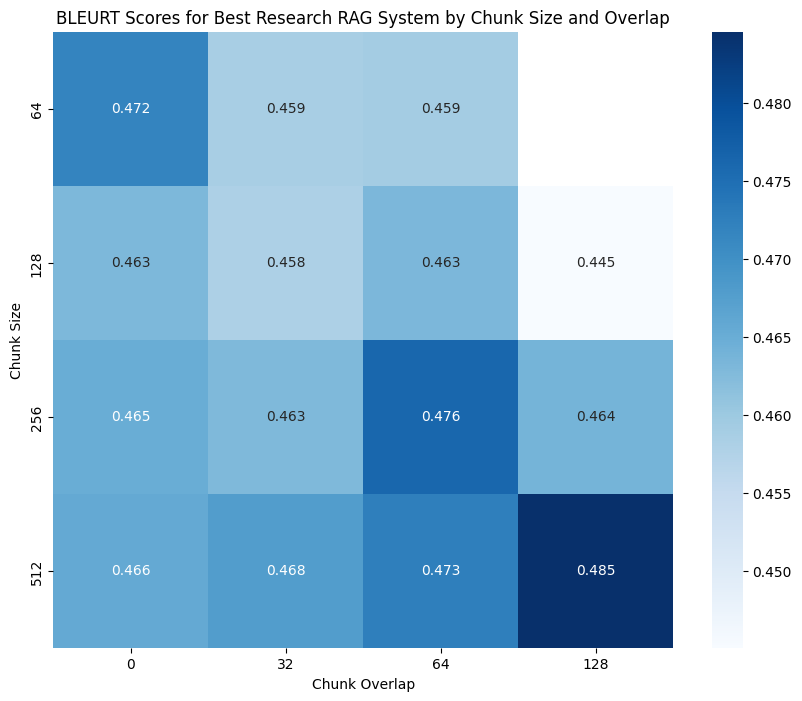

Best chunk size for research: 512
Best chunk overlap for research: 128


In [ ]:
# @title Research
df_chunk_params_r_results = chunk_params_experiment(
    persona="research",
    config=RAG_best_LLM_research_config,
    base_embedding_model=best_embedding_model_r,
    df_path="data/interim/chunk_params_experiment_r_df.pkl",
    force_run=False,
)

df_chunk_params_r_results_filtered = df_chunk_params_r_results[
    ["retrieval_chunk_size", "retrieval_chunk_overlap", "bleurt"]
]

print(df_chunk_params_r_results_filtered.groupby(["retrieval_chunk_size"])["bleurt"].mean())

# Pivot the table
pivot_chunk_params_r = df_chunk_params_r_results_filtered.pivot(
    index="retrieval_chunk_size", columns="retrieval_chunk_overlap", values="bleurt"
)
display(pivot_chunk_params_r)

# Heatmap Visualization
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(pivot_chunk_params_r, annot=True, cmap="Blues", fmt=".3f")
plt.title("BLEURT Scores for Best Research RAG System by Chunk Size and Overlap")
plt.ylabel("Chunk Size")
plt.xlabel("Chunk Overlap")
plt.savefig("reports/figures/chunk_param_experiment_r.png")
plt.show()

# Sort df_chunk_params_r_results_filtered by bleurt
df_chunk_params_r_results_filtered = df_chunk_params_r_results_filtered.sort_values(by="bleurt", ascending=False)
best_chunk_size_r = df_chunk_params_r_results_filtered.iloc[0]["retrieval_chunk_size"]
best_chunk_overlap_r = df_chunk_params_r_results_filtered.iloc[0]["retrieval_chunk_overlap"]
print(f"Best chunk size for research: {best_chunk_size_r}")
print(f"Best chunk overlap for research: {best_chunk_overlap_r}")

- Optimal Zone: The highest BLEURT scores cluster around a chunk size of 512 with chunk overlaps in the range of 64 to 128. This sweet spot suggests that research systems benefit from sizable chunks with a moderate degree of overlap.
- Overlap Impact: Within a fixed chunk size, increasing overlap generally leads to higher BLEURT scores, highlighting the value of partial redundancy in retrieved passages for complex research-oriented tasks.
- Chunk Size Sensitivity: At lower chunk sizes (64-256), the BLEURT scores are lower and exhibit more variation, indicating insufficient context for the LLM to process.

retrieval_chunk_size
64     0.447454
128    0.451159
256    0.447658
512    0.453973
Name: bleurt, dtype: float64

retrieval_chunk_overlap,0,32,64,128
retrieval_chunk_size,,,,
64,0.454874,0.448974,0.438514,NaN
128,0.449024,0.449264,0.465486,0.440862
256,0.445787,0.438993,0.453767,0.452083
512,0.439082,0.461551,0.458209,0.457052


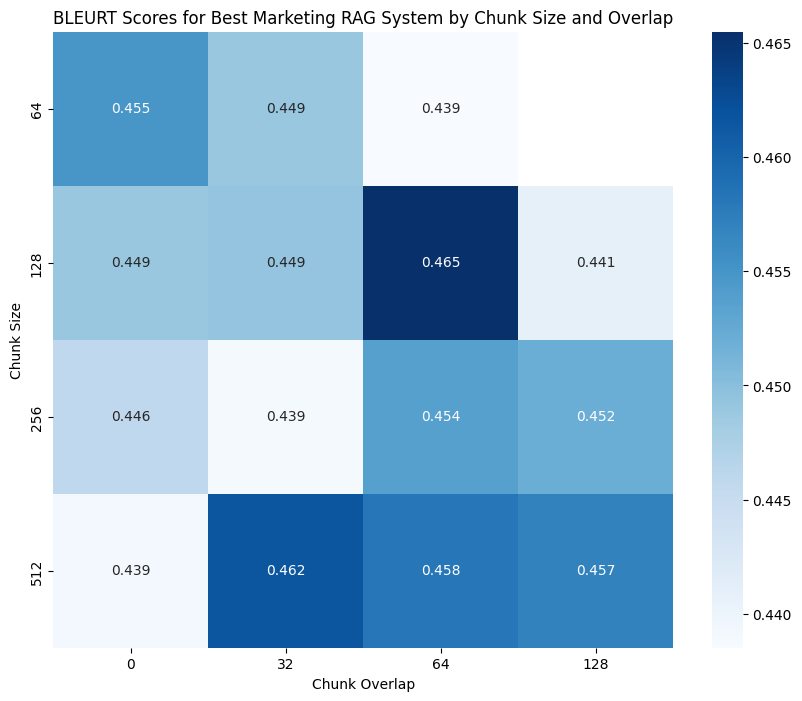

Best chunk size for marketing: 128
Best chunk overlap for marketing: 64


In [ ]:
# @title Marketing
df_chunk_params_m_results = chunk_params_experiment(
    persona="marketing",
    config=RAG_best_LLM_marketing_config,
    base_embedding_model=best_embedding_model_m,
    df_path="data/interim/chunk_params_experiment_m_df.pkl",
    force_run=False,
)

df_chunk_params_m_results_filtered = df_chunk_params_m_results[
    ["retrieval_chunk_size", "retrieval_chunk_overlap", "bleurt"]
]

# Understand chunk size relationship
display(df_chunk_params_m_results_filtered.groupby(["retrieval_chunk_size"])["bleurt"].mean())

# Pivot
pivot_chunk_params_m = df_chunk_params_m_results_filtered.pivot(
    index="retrieval_chunk_size", columns="retrieval_chunk_overlap", values="bleurt"
)
display(pivot_chunk_params_m)

# Heatmap Visualization
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(pivot_chunk_params_m, annot=True, cmap="Blues", fmt=".3f")
plt.title("BLEURT Scores for Best Marketing RAG System by Chunk Size and Overlap")
plt.ylabel("Chunk Size")
plt.xlabel("Chunk Overlap")
plt.savefig("reports/figures/chunk_param_experiment_m.png")
plt.show()

# Sort df_chunk_params_m_results_filtered by bleurt
df_chunk_params_m_results_filtered = df_chunk_params_m_results_filtered.sort_values(by="bleurt", ascending=False)
best_chunk_size_m = df_chunk_params_m_results_filtered.iloc[0]["retrieval_chunk_size"]
best_chunk_overlap_m = df_chunk_params_m_results_filtered.iloc[0]["retrieval_chunk_overlap"]
print(f"Best chunk size for marketing: {best_chunk_size_m}")
print(f"Best chunk overlap for marketing: {best_chunk_overlap_m}")

- Distinct Pattern: In contrast to research, the marketing heatmap shows a less concentrated zone of high BLEURT scores. Good performance appears more evenly distributed across different chunk sizes and overlaps.
- Moderate Overlap Preference: A slight trend favors chunk overlaps in the 32-128 range, especially with mid-sized chunks (around 256). This aligns with the previous observation that some redundancy is beneficial for marketing tasks.
- Chunk Size Flexibility: The less pronounced impact of chunk size suggests that marketing systems might be somewhat more robust to variations in this parameter.

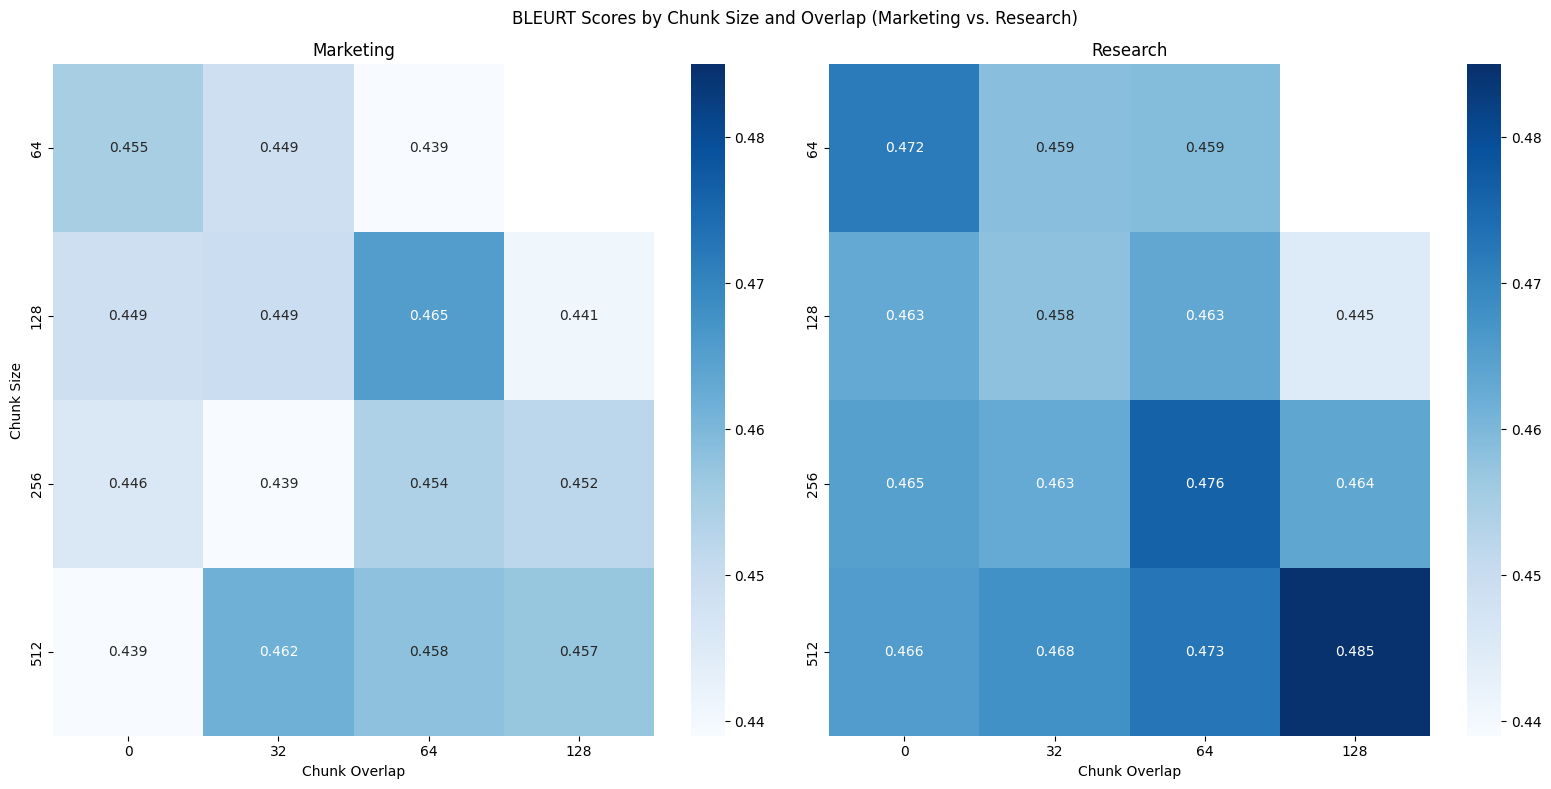

In [ ]:
# @title Combined Visualization for Report
# Side-by-Side Heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))  # Adjusted figsize

# Marketing Heatmap (axes[0])
sns.heatmap(pivot_chunk_params_m, annot=True, cmap="Blues", fmt=".3f", ax=axes[0], vmin=0.439, vmax=0.485)
axes[0].set_title("Marketing")
axes[0].set_ylabel("Chunk Size")
axes[0].set_xlabel("Chunk Overlap")

# Research Heatmap (axes[1])
sns.heatmap(pivot_chunk_params_r, annot=True, cmap="Blues", fmt=".3f", ax=axes[1], vmin=0.439, vmax=0.485)
axes[1].set_title("Research")
axes[1].set_ylabel("")  # Remove duplicate y label
axes[1].set_xlabel("Chunk Overlap")

# Overall adjustments
fig.suptitle("BLEURT Scores by Chunk Size and Overlap (Marketing vs. Research)")
plt.tight_layout()
plt.savefig("reports/figures/chunk_param_experiment_combined.png")
plt.show()

#### (For Future) Determine optimal configuration of retrieval parameters

This is reserved for future work (e.g., adjusting the number of queries returned). For now we will just use the defaults (similarity search, 5 queries returned)

#### Evaluate Using Full Dataset

In [ ]:
# @title Research
# Setup configs for best research
## Inherit from RAG_best_LLM_research_config
RAG_mistral_optimized_retrieval_r_config = copy.deepcopy(RAG_best_LLM_research_config)

## Replace arguments for base_embedding_model, chunk_size_and chunk_overlap from prior experiments
RAG_mistral_optimized_retrieval_r_config["name"] = "Mistral Research LLM Retrieval Opt"
RAG_mistral_optimized_retrieval_r_config["retrieval_embedding_model"] = best_embedding_model_r
RAG_mistral_optimized_retrieval_r_config["retrieval_chunk_size"] = best_chunk_size_r
RAG_mistral_optimized_retrieval_r_config["retrieval_chunk_overlap"] = best_chunk_overlap_r
export_dicts_to_json(RAG_mistral_optimized_retrieval_r_config, "RAG_mistral_optimized_retrieval_r_config.json")

# print("Config File")
# pprint(RAG_mistral_optimized_retrieval_r_config)

# Setup RAG based on config
RAG_mistral_optimized_retrieval_r = setup_RAG_based_on_config(
    config=RAG_mistral_optimized_retrieval_r_config, name="Mistral Research LLM Retrieval Opt"
)

# print("RAG Object Config")
# pprint(RAG_mistral_optimized_retrieval_r.get_config())

# Add results to dataframe
df_results = add_results_to_df(
    rag_system=RAG_mistral_optimized_retrieval_r, persona="research", use_subset=False, force_run=False
)

Configuration files have been successfully exported to the models directory.
Updating chunk parameters to chunk_size=512 and chunk_overlap=128...
Splitting documents with chunk_size=512 and chunk_overlap=128...
Generated splits: 3897 arxiv, 156 wiki, 326 web, totaling 4379.
Initializing vector store with multi-qa-mpnet-base-dot-v1 model, 512 chunk size, 128 chunk overlap
Vector store initialized
Updating base embedding model to avsolatorio/GIST-Embedding-v0
Splitting documents with chunk_size=512 and chunk_overlap=128...
Generated splits: 3897 arxiv, 156 wiki, 326 web, totaling 4379.
Initializing vector store with avsolatorio/GIST-Embedding-v0 model, 512 chunk size, 128 chunk overlap
Vector store initialized
Results already exist for Mistral Research LLM Retrieval Opt and force_run is False. Skipping evaluation.


In [ ]:
# @title Marketing
# Setup configs for best marketing
## Inherit from RAG_best_LLM_marketing_config
RAG_mistral_optimized_retrieval_m_config = copy.deepcopy(RAG_best_LLM_marketing_config)

## Replace arguments for base_embedding_model, chunk_size_and chunk_overlap from prior experiments
RAG_mistral_optimized_retrieval_m_config["name"] = "Mistral Marketing LLM Retrieval Opt"
RAG_mistral_optimized_retrieval_m_config["retrieval_embedding_model"] = best_embedding_model_m
RAG_mistral_optimized_retrieval_m_config["retrieval_chunk_size"] = best_chunk_size_m
RAG_mistral_optimized_retrieval_m_config["retrieval_chunk_overlap"] = best_chunk_overlap_m
export_dicts_to_json(RAG_mistral_optimized_retrieval_m_config, "RAG_mistral_optimized_retrieval_m_config.json")

# print("Config File")
# pprint(RAG_mistral_optimized_retrieval_m_config)

# Setup RAG based on config
RAG_mistral_optimized_retrieval_m = setup_RAG_based_on_config(
    config=RAG_mistral_optimized_retrieval_m_config, name="Mistral Marketing LLM Retrieval Opt"
)

# print("RAG Object Config")
# pprint(RAG_mistral_optimized_retrieval_m.get_config())

# Add results to dataframe
df_results = add_results_to_df(
    rag_system=RAG_mistral_optimized_retrieval_m, persona="marketing", use_subset=False, force_run=False
)

Configuration files have been successfully exported to the models directory.
Updating chunk parameters to chunk_size=128 and chunk_overlap=64...
Splitting documents with chunk_size=128 and chunk_overlap=64...
Generated splits: 20661 arxiv, 705 wiki, 1440 web, totaling 22806.
Initializing vector store with avsolatorio/GIST-Embedding-v0 model, 128 chunk size, 64 chunk overlap
Vector store initialized
Updating base embedding model to all-MiniLM-L6-v2
Splitting documents with chunk_size=128 and chunk_overlap=64...
Generated splits: 20661 arxiv, 705 wiki, 1440 web, totaling 22806.
Initializing vector store with all-MiniLM-L6-v2 model, 128 chunk size, 64 chunk overlap
Vector store initialized
Results already exist for Mistral Marketing LLM Retrieval Opt and force_run is False. Skipping evaluation.


In [ ]:
df_results[["RAG_system", "bleurt"]].sort_values(["bleurt"], ascending=False)

,RAG_system,bleurt
9,Mistral Research LLM Retrieval Opt,0.493038
11,Mistral Research LLM Retrieval Template Opt,0.485656
8,Mistral Research LLM Opt,0.473953
4,Mistral Marketing LLM Retrieval Opt,0.473707
10,Mistral Research Base,0.471358
3,Mistral Marketing LLM Opt,0.467272
5,Mistral Marketing LLM Retrieval Template Opt,0.464329
2,Mistral Marketing Base,0.463861
7,Cohere Research LLM Opt,0.450446
1,Cohere Marketing LLM Opt,0.446718


### Step 2.3 Template Optimization

In [ ]:
# @title Helper Functions
def template_experiment(persona, config, prompt_dict, df_path, use_subset=True, force_run=False):
    """
    Conducts experiments to evaluate the impact of prompts.

    This function iterates over prompt templates, and evaluates the RAG system's performance under each configuration.
    The evaluation results are aggregated into a DataFrame. If the results already exist and `force_run` is False,
    the existing results are loaded from a pickle file. Otherwise, the function generates new results,
    which are then saved to a pickle file for future reference.

    Parameters:
    - persona (str): The target persona for the experiment (e.g., "marketing", "research").
    - config (dict): A dictionary containing the configurations for the model.
    - prompt_dict (dict): A dictionary containing the prompts for the model.
    - df_path (str, optional): Path to save or load the DataFrame containing the results.
    - use_subset (bool, optional): Whether to use a subset of data for the experiment. Defaults to True.
    - force_run (bool, optional): Forces the experiment to run even if results exist at `df_path`. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing the evaluation results for each combination of chunk size and overlap.
    """
    if os.path.exists(df_path) and not force_run:
        df_results = pd.read_pickle(df_path)
        return df_results

    else:
        rag_system = setup_RAG_based_on_config(config=config, name=f"{config['name']}_{list(prompt_dict.keys())[0]}")
        print(f"Original RAG System Config: {rag_system.get_config()}")

        for template_name, template in tqdm(prompt_dict.items()):
            rag_system.set_prompt_template(template)
            rag_system.rename(name=f"{config['name']}_{template_name}")
            print(f"Updated RAG System Config: {rag_system.get_config()}")
            df_results = add_results_to_df(
                rag_system=rag_system, persona=persona, use_subset=use_subset, df_path=df_path, force_run=force_run
            )

        return df_results


def transform_df_prompts(df):
    """
    Transforms the DataFrame by extracting specific parts from 'RAG_system', creating new columns,
    and adjusting the structure as per requirements.

    Parameters:
    - df: pandas.DataFrame - The DataFrame to transform.

    Returns:
    - pandas.DataFrame - The transformed DataFrame.
    """
    df = df.copy()

    # Extracting the base part (up to "Opt")
    df["RAG_system_base"] = df["RAG_system"].str.extract(r"(^.*Opt)")

    # Extracting the template part (after the first "_")
    df["Template"] = df["RAG_system"].apply(lambda x: x.split("_", 1)[1] if "_" in x else x)

    # Extract template number
    df["Template_Number"] = df["Template"].str.extract(r"(\d+)")

    # Extract few_shot_flag
    df["Type"] = df["Template"].apply(lambda x: "With Examples" if x.endswith("_few_shot") else "No Examples")

    # Delete RAG_system
    df = df.drop("RAG_system", axis=1)

    # Rename RAG_system_base as RAG_system
    df = df.rename(columns={"RAG_system_base": "RAG_system"})

    # Reorder columns
    df = df[["Persona", "RAG_system", "Template", "Template_Number", "Type", "bleurt", "Responses"]]

    # Sort in descending order for bleurt
    df = df.sort_values("bleurt", ascending=False)

    return df

In [ ]:
# @title Research
df_prompts_r_results = template_experiment(
    persona="research",
    config=RAG_mistral_optimized_retrieval_r_config,
    prompt_dict=research_template_dict,
    df_path="data/interim/prompt_experiment_results_r_df.pkl",
    use_subset=True,
    force_run=False,
)

In [ ]:
df_prompts_r_results = transform_df_prompts(df_prompts_r_results)
display(df_prompts_r_results)

best_template_name_r = df_prompts_r_results.iloc[0]["Template"]
best_template_r = research_template_dict[best_template_name_r]
print(f"Best Template for Research: {best_template_r}")

,Persona,RAG_system,Template,Template_Number,Type,bleurt,Responses
0,research,Mistral Research LLM Retrieval Opt,research_template_1,1,No Examples,0.481331,[Large language models (LLMs) are an advanced ...
5,research,Mistral Research LLM Retrieval Opt,research_template_3_few_shot,3,With Examples,0.480010,[Large language models (LLMs) serve as reposit...
3,research,Mistral Research LLM Retrieval Opt,research_template_2_few_shot,2,With Examples,0.470337,[Large language models (LLMs) serve a crucial ...
4,research,Mistral Research LLM Retrieval Opt,research_template_3,3,No Examples,0.470206,[Large language models (LLMs) serve several pu...
2,research,Mistral Research LLM Retrieval Opt,research_template_2,2,No Examples,0.469262,[Large language models (LLMs) have emerged as ...
1,research,Mistral Research LLM Retrieval Opt,research_template_1_few_shot,1,With Examples,0.462756,[Large language models (LLMs) are a type of ar...


Best Template for Research: 
[INST] Deliver an in-depth technical exploration, focusing on the underpinnings, theoretical models, and practical applications. Highlight recent advancements and comparative analysis with prior models.
Context: {context}

Question: {question}
[/INST]



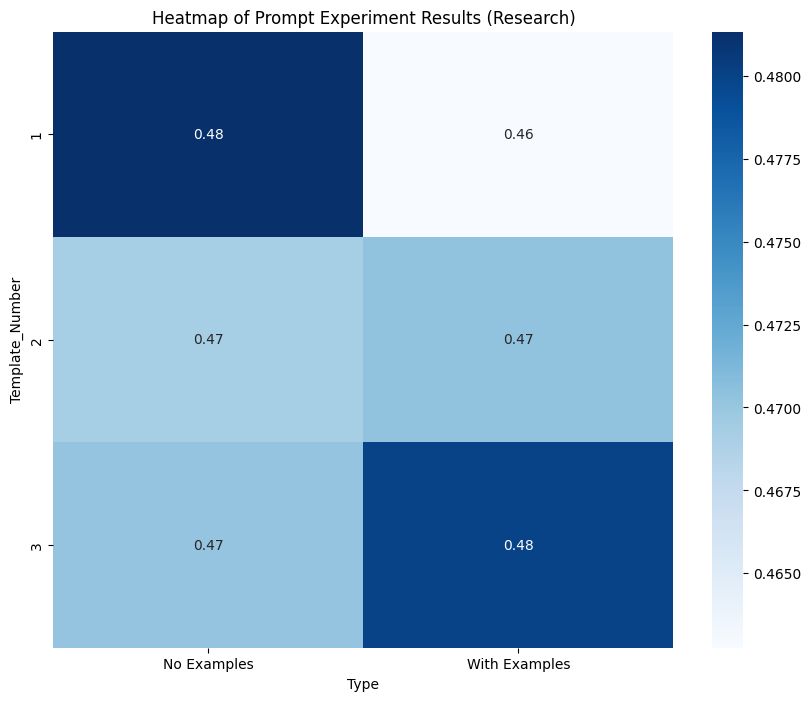

In [ ]:
# Heatmap a pivot table
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_prompts_r_results.pivot_table(
        index="Template_Number", columns="Type", values="bleurt", aggfunc="mean", margins=False
    ),
    annot=True,
    fmt=".2f",
    cmap="Blues",
)
plt.title("Heatmap of Prompt Experiment Results (Research)")
plt.savefig("reports/figures/prompt_experiment_results_r_heatmap.png")
plt.show()

Interestingly, although few shot learning does lead to improvements overall, it doesn't for the default template (template 1). The best results is still the default template (template 1) without the examples. This could be due to the quality of the synthetic examples used for few shot prompts. In future, further experimentation here could be warranted.

In [ ]:
# @title Marketing
df_prompts_m_results = template_experiment(
    persona="marketing",
    config=RAG_mistral_optimized_retrieval_m_config,
    prompt_dict=marketing_template_dict,
    df_path="data/interim/prompt_experiment_results_m_df.pkl",
    use_subset=True,
    force_run=False,
)

In [ ]:
df_prompts_m_results = transform_df_prompts(df_prompts_m_results)
display(df_prompts_m_results)

best_template_name_m = df_prompts_m_results.iloc[0]["Template"]
best_template_m = marketing_template_dict[best_template_name_m]
print(f"Best Template for Marketing: {best_template_m}")

,Persona,RAG_system,Template,Template_Number,Type,bleurt,Responses
5,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_3_few_shot,3,With Examples,0.456771,[Large language models are a type of artificia...
4,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_3,3,No Examples,0.454934,[Large language models play a crucial role in ...
1,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_1_few_shot,1,With Examples,0.445937,[Answer: Large language models serve a crucial...
3,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_2_few_shot,2,With Examples,0.441177,[Answer: Large language models are a powerful ...
0,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_1,1,No Examples,0.438527,[Large language models are a critical componen...
2,marketing,Mistral Marketing LLM Retrieval Opt,marketing_template_2,2,No Examples,0.431672,[Large language models are a type of artificia...


Best Template for Marketing: 
[INST] With the context given, craft a clear, concise summary aimed at a general audience. Highlight the practical benefits, current trends in the industry, and the strategic importance of the technology. Ensure the response is grounded solely in the context provided.
Example 1:
Question: How do neural networks learn from data?
Answer: According to the provided context, neural networks improve their functionality over time by analyzing data, learning from errors, and fine-tuning their algorithms to enhance user experience with technology.

Example 2:
Question: What are the implications of AI in enhancing cybersecurity?
Answer: From the context, AI's role in cybersecurity involves using advanced algorithms to quickly identify and neutralize threats, making digital platforms safer and more reliable for users.

Context: {context}

Question: {question}
[/INST]



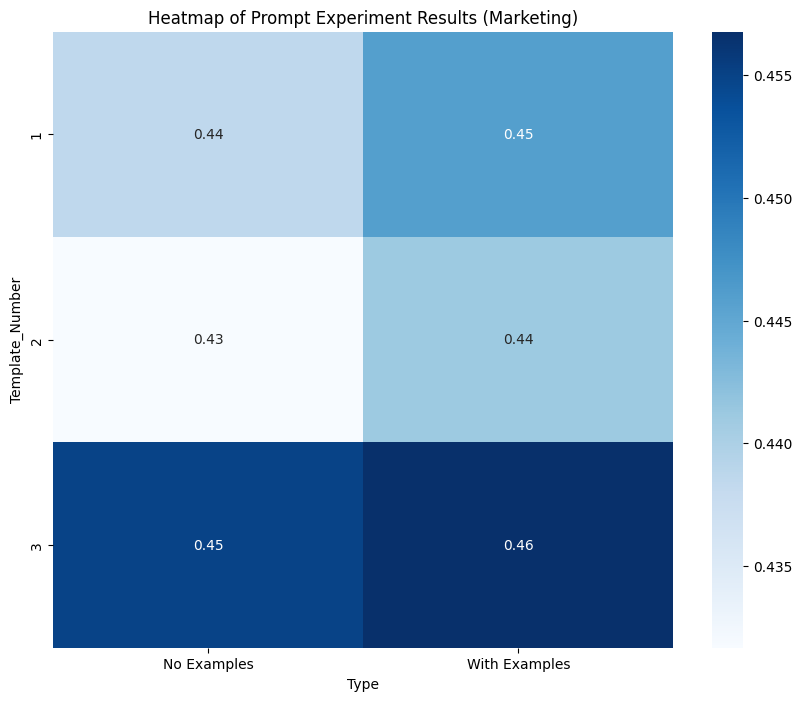

In [ ]:
# Heatmap a pivot table
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_prompts_m_results.pivot_table(
        index="Template_Number", columns="Type", values="bleurt", aggfunc="mean", margins=False
    ),
    annot=True,
    fmt=".2f",
    cmap="Blues",
)
plt.title("Heatmap of Prompt Experiment Results (Marketing)")
plt.savefig("reports/figures/prompt_experiment_results_m_heatmap.png")
plt.show()

Here, template 3 is shown to be superior and few shot examples lead to consistent improvements across all templates.

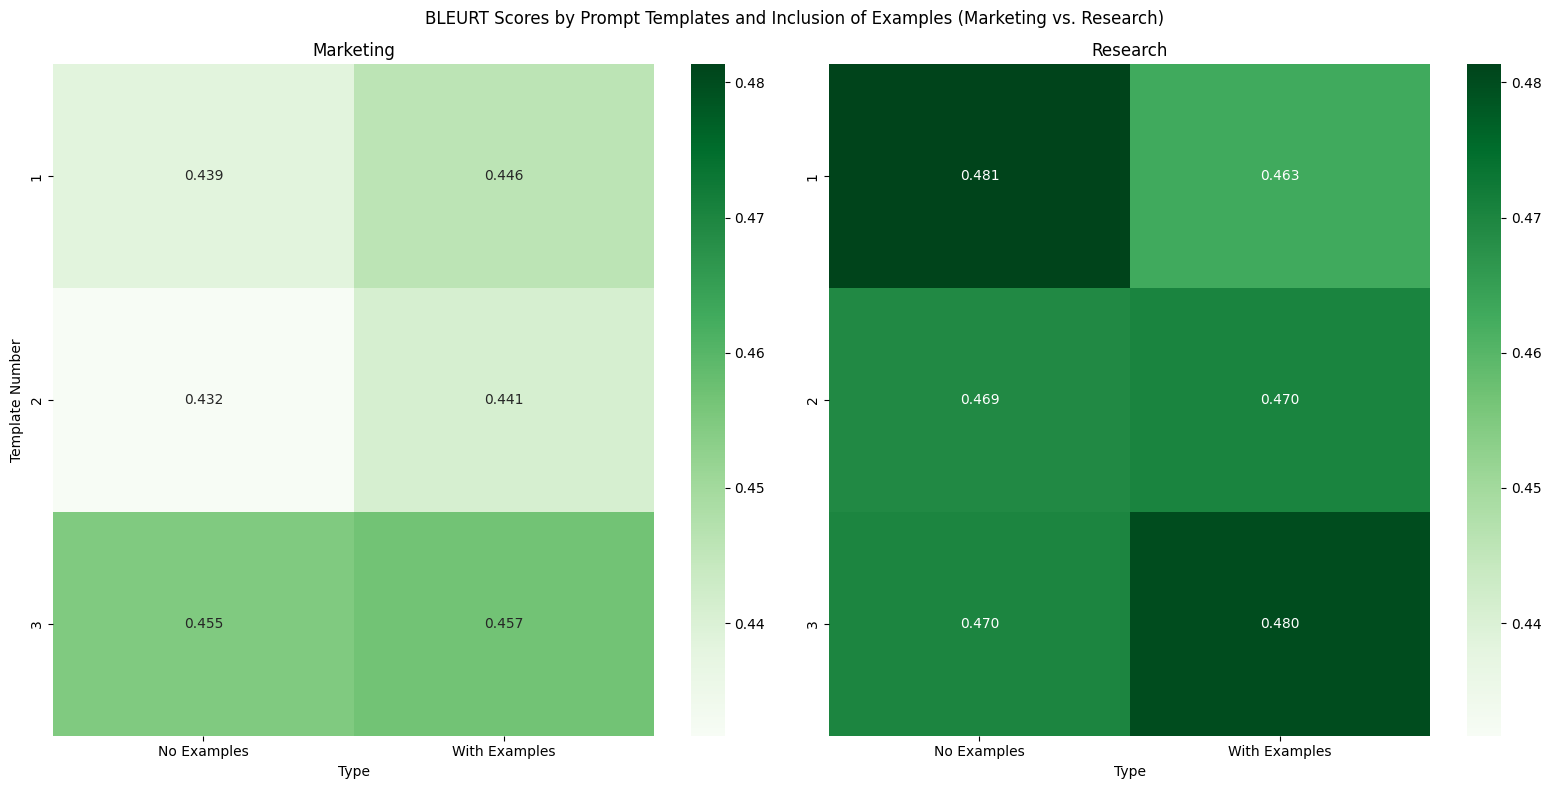

In [ ]:
# @title Combined Visualization for Report
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Your existing research and marketing code (keep as is) ---------

# Side-by-Side Heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Calculate the overall BLEURT range
min_bleurt = min(df_prompts_r_results['bleurt'].min(), df_prompts_m_results['bleurt'].min())
max_bleurt = max(df_prompts_r_results['bleurt'].max(), df_prompts_m_results['bleurt'].max())

# Marketing Heatmap (axes[0])
sns.heatmap(
    df_prompts_m_results.pivot_table(
        index="Template_Number", columns="Type", values="bleurt", aggfunc="mean", margins=False
    ),
    annot=True,
    fmt=".3f",
    cmap="Greens",
    vmin=min_bleurt,
    vmax=max_bleurt,
    ax=axes[0]
)
axes[0].set_title("Marketing")
axes[0].set_ylabel("Template Number")
axes[0].set_xlabel("Type")

# Research Heatmap (axes[1])
sns.heatmap(
    df_prompts_r_results.pivot_table(
        index="Template_Number", columns="Type", values="bleurt", aggfunc="mean", margins=False
    ),
    annot=True,
    fmt=".3f",
    cmap="Greens",
    vmin=min_bleurt,
    vmax=max_bleurt,
    ax=axes[1]
)
axes[1].set_title("Research")
axes[1].set_ylabel("")
axes[1].set_xlabel("Type")

# Overall adjustments
fig.suptitle("BLEURT Scores by Prompt Templates and Inclusion of Examples (Marketing vs. Research)")
plt.tight_layout()
plt.savefig("reports/figures/prompt_experiment_results_combined.png")
plt.show()


### Step 3: Final Evaluation

In [ ]:
# @title Research

# Update config files
RAG_mistral_final_r_config = copy.deepcopy(RAG_mistral_optimized_retrieval_r_config)
RAG_mistral_final_r_config["prompt_template"] = best_template_r
print("\nRAG_mistral_final_r_config:")
pprint(RAG_mistral_final_r_config)
export_dicts_to_json([RAG_mistral_final_r_config], ["RAG_mistral_final_r_config"])

# Setup the RAG systems
RAG_mistral_final_r = setup_RAG_based_on_config(
    config=RAG_mistral_final_r_config, name="Mistral Research LLM Retrieval Template Opt"
)
print("\nRAG_mistral_final_r config:")
pprint(RAG_mistral_final_r.get_config())

# Evaluate and add results to dataframe
results_df = add_results_to_df(rag_system=RAG_mistral_final_r, persona="research", use_subset=False, force_run=False)


RAG_mistral_final_r_config:
{'llm_kwargs': {'mistral_do_sample': True,
                'mistral_max_length': 300,
                'mistral_repetition_penalty': 1.0,
                'mistral_temperature': 0.8,
                'mistral_top_p': 0.9500000000000001},
 'llm_type': 'mistral',
 'name': 'Mistral Research LLM Retrieval Opt',
 'prompt_template': '\n'
                    '[INST] Deliver an in-depth technical exploration, '
                    'focusing on the underpinnings, theoretical models, and '
                    'practical applications. Highlight recent advancements and '
                    'comparative analysis with prior models.\n'
                    'Context: {context}\n'
                    '\n'
                    'Question: {question}\n'
                    '[/INST]\n',
 'retrieval_chunk_overlap': 128,
 'retrieval_chunk_size': 512,
 'retrieval_embedding_model': 'avsolatorio/GIST-Embedding-v0',
 'search_kwargs': {'k': 3},
 'search_type': 'similarity'}
Configuration 

In [ ]:
# @title Marketing

# Update config files
RAG_mistral_final_m_config = copy.deepcopy(RAG_mistral_optimized_retrieval_m_config)
RAG_mistral_final_m_config["prompt_template"] = best_template_m
# print("\nRAG_mistral_final_m_config:")
# pprint(RAG_mistral_final_m_config)
export_dicts_to_json([RAG_mistral_final_m_config], ["RAG_mistral_final_m_config"])

# Setup the RAG system
RAG_mistral_final_m = setup_RAG_based_on_config(
    config=RAG_mistral_final_m_config, name="Mistral Marketing LLM Retrieval Template Opt"
)
# print("\nRAG_mistral_final_m config:")
# pprint(RAG_mistral_final_m.get_config())

# Evaluate and add results to dataframe
results_df = add_results_to_df(rag_system=RAG_mistral_final_m, persona="marketing", use_subset=False, force_run=False)

Configuration files have been successfully exported to the models directory.
Updating chunk parameters to chunk_size=128 and chunk_overlap=64...
Splitting documents with chunk_size=128 and chunk_overlap=64...
Generated splits: 20661 arxiv, 705 wiki, 1440 web, totaling 22806.
Initializing vector store with avsolatorio/GIST-Embedding-v0 model, 128 chunk size, 64 chunk overlap
Vector store initialized
Updating base embedding model to all-MiniLM-L6-v2
Splitting documents with chunk_size=128 and chunk_overlap=64...
Generated splits: 20661 arxiv, 705 wiki, 1440 web, totaling 22806.
Initializing vector store with all-MiniLM-L6-v2 model, 128 chunk size, 64 chunk overlap
Vector store initialized
Results already exist for Mistral Marketing LLM Retrieval Template Opt and force_run is False. Skipping evaluation.


In [ ]:
# @title Cleanup Dataframe
def prepare_final_results_df(df, export_path):
    """
    Prepares the final results DataFrame by performing several operations:
    1. Makes a copy of the input DataFrame and cleans/consolidates it.
    2. Drops specific columns deemed unnecessary for the final results.
    3. Renames columns for consistency.
    4. Reorders columns to a specified order.
    5. Sorts the DataFrame by RAG system and BLEURT scores.
    6. Splits the DataFrame into marketing and research personas.
    7. Exports the full, marketing, and research DataFrames to CSV files.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.
        export_path (str): The directory path where CSV files will be saved.

    Returns:
        tuple: A tuple containing the full, marketing, and research DataFrames.
    """
    df = df.copy()

    # Clean and consolidate LLM parameters
    df = clean_and_consolidate_df(df)

    # Drop unnecessary columns
    unnecessary_columns = [
        "Data_type",
        "mistral_max_length",
        "mistral_temperature",
        "mistral_top_p",
        "mistral_do_sample",
        "mistral_repetition_penalty",
        "cohere_max_length",
        "cohere_top_p",
        "cohere_temperature",
        "cohere_frequency_penalty",
        "name",
    ]
    df = df.drop(columns=unnecessary_columns)

    # Rename columns for consistency
    rename_columns = {
        "retrieval_embedding_model": "Retrieval_embedding_model",
        "retrieval_chunk_size": "Retrieval_chunk_size",
        "retrieval_chunk_overlap": "Retrieval_chunk_overlap",
        "search_type": "Retrieval_search_type",
        "search_kwargs": "Retrieval_search_kwargs",
        "prompt_template": "Prompt_template",
        "llm_type": "LLM_type",
        "bleurt": "BLEURT",
        "responses": "Responses",
        "max_length": "LLM_max_length",
        "temperature": "LLM_temperature",
        "top_p": "LLM_top_p",
        "repetition_penalty": "LLM_repetition_penalty",
        "do_sample": "LLM_do_sample",
    }
    df = df.rename(columns=rename_columns)

    # Reorder columns
    ordered_columns = [
        "Persona",
        "RAG_system",
        "Retrieval_embedding_model",
        "Retrieval_chunk_size",
        "Retrieval_chunk_overlap",
        "Retrieval_search_type",
        "Retrieval_search_kwargs",
        "Prompt_template",
        "LLM_type",
        "LLM_max_length",
        "LLM_temperature",
        "LLM_top_p",
        "LLM_repetition_penalty",
        "LLM_do_sample",
        "Responses",
        "BLEURT",
    ]
    df = df[ordered_columns]

    # Specify ordering of RAG_systems and sort
    rag_system_order_dict = {
        "Cohere Marketing Base": 0,
        "Cohere Marketing LLM Opt": 1,
        "Mistral Marketing Base": 2,
        "Mistral Marketing LLM Opt": 3,
        "Mistral Marketing LLM Retrieval Opt": 4,
        "Mistral Marketing LLM Retrieval Template Opt": 5,
        "Cohere Research Base": 6,
        "Cohere Research LLM Opt": 7,
        "Mistral Research Base": 8,
        "Mistral Research LLM Opt": 9,
        "Mistral Research LLM Retrieval Opt": 10,
        "Mistral Research LLM Retrieval Template Opt": 11,
    }
    df["RAG_system_order"] = df["RAG_system"].map(rag_system_order_dict)
    df = df.sort_values(by=["RAG_system_order", "BLEURT"], ascending=[True, False])
    df = df.drop(columns=["RAG_system_order"])

    # Reindex
    df = df.reset_index(drop=True)

    # Split into two DataFrames
    df_marketing = df[df["Persona"] == "marketing"]
    df_research = df[df["Persona"] == "research"]

    # Export to CSV
    df.to_csv(os.path.join(export_path, "final_results_df_m_r.csv"), index=False)
    df_marketing.to_csv(os.path.join(export_path, "final_results_df_m.csv"), index=False)
    df_research.to_csv(os.path.join(export_path, "final_results_df_r.csv"), index=False)

    return df, df_marketing, df_research


results_df_c, results_df_c_m, results_df_c_r = prepare_final_results_df(results_df, export_path="data/final")

In [ ]:
# @title Get best RAG_system for marketing
display(
    results_df_c_m[["Persona", "RAG_system", "BLEURT"]].sort_values(by="BLEURT", ascending=False).reset_index(drop=True)
)
print("\nBEST MARKETING RAG SYSTEM")
display(
    results_df_c_m[["Persona", "RAG_system", "BLEURT"]]
    .sort_values(by="BLEURT", ascending=False)
    .reset_index(drop=True)
    .head(1)
)

,Persona,RAG_system,BLEURT
0,marketing,Mistral Marketing LLM Retrieval Opt,0.473707
1,marketing,Mistral Marketing LLM Opt,0.467272
2,marketing,Mistral Marketing LLM Retrieval Template Opt,0.464329
3,marketing,Mistral Marketing Base,0.463861
4,marketing,Cohere Marketing LLM Opt,0.446718
5,marketing,Cohere Marketing Base,0.432610



BEST MARKETING RAG SYSTEM


,Persona,RAG_system,BLEURT
0,marketing,Mistral Marketing LLM Retrieval Opt,0.473707


It looks like the template optimization for marketing actually led to a deterioration in performance in terms of BLEURT, but let's manually investigate the examples for the top three models

In [ ]:
for idx in range(20):
    print(f"Index: {idx}")
    print_response_and_reference(
        results_df_c_m,
        [
            "Mistral Marketing LLM Opt",
            "Mistral Marketing LLM Retrieval Opt",
            "Mistral Marketing LLM Retrieval Template Opt",
        ],
        idx,
        "marketing",
    )

Index: 0
Question: 
What purpose do large language models serve in the field of natural language processing?

Reference marketing Response:
Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical character recognition, handwriting recognition, grammar induction, and information retrieval.

Response for Mistral Marketing LLM Opt:
Large language models are a powerful tool in the field of natural language processing, serving the purpose of generating and understanding human language. These models are capable of performing a wide range of language tasks, including language translation, text summarization, and language generation.However, there are limitations to large language models, such as the potential for biased or inaccurate outputs. Additionally, the use of large language models raises societal concerns about the impact on human communication a

To systematically assess the effectiveness of three RAG systems (Mistral Marketing LLM Opt, Mistral Marketing LLM Retrieval Opt, and Mistral Marketing LLM Retrieval Template Opt) across a subsample of text generated (20), we employed a structured evaluation based on five criteria:

- **Accuracy**: Correctness and relevance of the response.
- **Comprehensiveness**: The breadth of coverage within the response.
- **Relevance to Marketing**: The degree to which the response provides marketing insights.
- **Clarity**: Understandability and coherence of the response.
- **Adherence to Reference Length**: How closely the response's length matches the reference.

Each response was scored by ChatGPT from 1 to 5 across these criteria, and averages were calculated for each model across all indices. The results are as follows:

- **Mistral Marketing LLM Opt**: Overall Average Score of 3.86
- **Mistral Marketing LLM Retrieval Opt**: Overall Average Score of 3.90
- **Mistral Marketing LLM Retrieval Template Opt**: Overall Average Score of 3.34

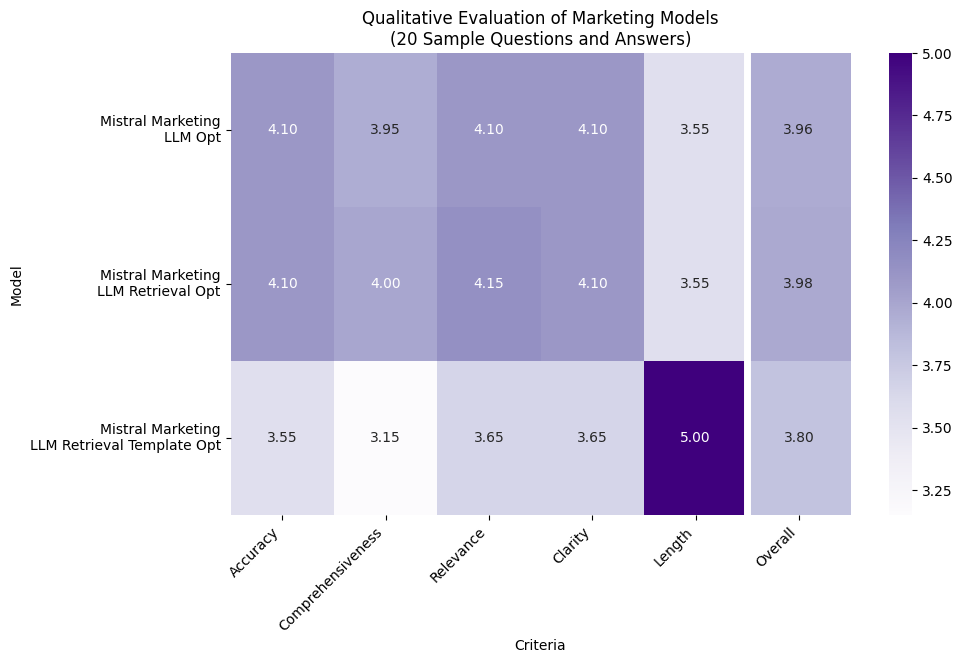

In [ ]:
# Scores provided for each model on each criteria per index
def chatGPT_evaluate_marketing_models(scores):
    """
    Evaluate the performance of three RAG systems (Mistral Marketing LLM Opt, Mistral Marketing LLM Retrieval Opt, and Mistral Marketing LLM Retrieval Template Opt) across ten indices
    """
    # Create DataFrame
    df_scores = pd.DataFrame(scores)

    # Calculate average for each model across all criteria
    df_scores["Average_Opt"] = df_scores[
        ["Accuracy_Opt", "Comprehensiveness_Opt", "Relevance_Opt", "Clarity_Opt", "Length_Opt"]
    ].mean(axis=1)
    df_scores["Average_Retrieval"] = df_scores[
        [
            "Accuracy_Retrieval",
            "Comprehensiveness_Retrieval",
            "Relevance_Retrieval",
            "Clarity_Retrieval",
            "Length_Retrieval",
        ]
    ].mean(axis=1)
    df_scores["Average_Template"] = df_scores[
        ["Accuracy_Template", "Comprehensiveness_Template", "Relevance_Template", "Clarity_Template", "Length_Template"]
    ].mean(axis=1)

    # Calculate overall average for each model
    average_scores = {
        "Model": [
            "Mistral Marketing\nLLM Opt",
            "Mistral Marketing\nLLM Retrieval Opt",
            "Mistral Marketing\nLLM Retrieval Template Opt",
        ],
        "Accuracy": [
            df_scores["Accuracy_Opt"].mean(),
            df_scores["Accuracy_Retrieval"].mean(),
            df_scores["Accuracy_Template"].mean(),
        ],
        "Comprehensiveness": [
            df_scores["Comprehensiveness_Opt"].mean(),
            df_scores["Comprehensiveness_Retrieval"].mean(),
            df_scores["Comprehensiveness_Template"].mean(),
        ],
        "Relevance": [
            df_scores["Relevance_Opt"].mean(),
            df_scores["Relevance_Retrieval"].mean(),
            df_scores["Relevance_Template"].mean(),
        ],
        "Clarity": [
            df_scores["Clarity_Opt"].mean(),
            df_scores["Clarity_Retrieval"].mean(),
            df_scores["Clarity_Template"].mean(),
        ],
        "Length": [
            df_scores["Length_Opt"].mean(),
            df_scores["Length_Retrieval"].mean(),
            df_scores["Length_Template"].mean(),
        ],
        "Overall": [
            df_scores["Average_Opt"].mean(),
            df_scores["Average_Retrieval"].mean(),
            df_scores["Average_Template"].mean(),
        ],
    }

    df_overall_averages = pd.DataFrame(average_scores)

    return df_overall_averages


scores = {
    "Index": list(range(20)),
    "Accuracy_Opt": [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Comprehensiveness_Opt": [4, 4, 3, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Relevance_Opt": [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Clarity_Opt": [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Length_Opt": [3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Accuracy_Retrieval": [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Comprehensiveness_Retrieval": [4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Relevance_Retrieval": [5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Clarity_Retrieval": [4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Length_Retrieval": [3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Accuracy_Template": [3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Comprehensiveness_Template": [2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
    "Relevance_Template": [3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Clarity_Template": [3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4],
    "Length_Template": [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
}

chatGPT_marketing_eval = chatGPT_evaluate_marketing_models(scores)

plt.figure(figsize=(10, 6))
sns.heatmap(chatGPT_marketing_eval.set_index("Model"), annot=True, fmt=".2f", cmap="Purples")
plt.title("Qualitative Evaluation of Marketing Models\n(20 Sample Questions and Answers)")
plt.xlabel("Criteria")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Model")
plt.axvline(x=list(chatGPT_marketing_eval.columns).index("Overall") - 1, color="white", linestyle="-", linewidth=5)
plt.savefig("reports/figures/chatGPT_marketing_eval.png")
plt.show()

Some qualitative observations from the provided sample text:

Mistral Marketing LLM Opt:

- Accuracy: This model tends to provide precise and relevant responses, closely adhering to the factual content of the reference responses.
- Comprehensiveness: It generally covers the breadth of the topics well but can occasionally include extraneous details that may not be necessary, slightly affecting the directness of the answer.
- Relevance to Marketing: The responses usually connect well with marketing strategies, showing a good understanding of how AI can be applied in this field.
- Clarity: The model's responses are clear and well-articulated, making them easy to understand.
- Adherence to Reference Length: The responses sometimes exceed the ideal length, indicating a tendency towards more detailed explanations that may not always be necessary.

Mistral Marketing LLM Retrieval Opt:

- Accuracy: This model consistently provides accurate information and is well-aligned with the reference responses, demonstrating a solid grasp of the subject matter.
- Comprehensiveness: Responses are thorough and typically encompass all the critical aspects needed to answer the questions comprehensively.
Relevance to Marketing: It has a strong inclination to relate AI's capabilities back to marketing applications, often offering insights on how these can influence marketing strategies.
- Clarity: Clarity is maintained across responses, with explanations conveyed in a straightforward and comprehensible manner.
Adherence to Reference Length: The model maintains a balance in response length, aligning well with the reference responses while providing complete information.

Mistral Marketing LLM Retrieval Template Opt:

- Accuracy: While generally accurate, this model may occasionally include less precise information compared to the other two models.
- Comprehensiveness: The responses can be somewhat brief and may not always delve into the topic as deeply as needed for full comprehension.
Relevance to Marketing: This model demonstrates an understanding of the relevance to marketing, though it may not always tie the technical aspects of AI to practical marketing applications as effectively as the other models.
- Clarity: The clarity of the responses is adequate but can be somewhat variable, with some responses potentially lacking the detail needed for complete clarity.
- Adherence to Reference Length: This model excels in matching the reference length, often providing concise responses that align well with the expected brevity.

Overall, the Mistral Marketing LLM Retrieval Opt model stands out as the most balanced across all criteria, effectively combining accuracy with comprehensive and relevant insights, clear explanations, and a suitable response length. The Mistral Marketing LLM Opt is comparable in many respects but tends to offer more extended responses. The Mistral Marketing LLM Retrieval Template Opt, while succinct, sometimes falls short in providing the depth and marketing relevance seen in the other models.

In [ ]:
# @title Get best RAG_system for research
display(
    results_df_c_r[["Persona", "RAG_system", "BLEURT"]].sort_values(by="BLEURT", ascending=False).reset_index(drop=True)
)
print("\nBEST RESEARCH RAG SYSTEM")
display(
    results_df_c_r[["Persona", "RAG_system", "BLEURT"]]
    .sort_values(by="BLEURT", ascending=False)
    .reset_index(drop=True)
    .head(1)
)

,Persona,RAG_system,BLEURT
0,research,Mistral Research LLM Retrieval Opt,0.493038
1,research,Mistral Research LLM Retrieval Template Opt,0.485656
2,research,Mistral Research LLM Opt,0.473953
3,research,Mistral Research Base,0.471358
4,research,Cohere Research LLM Opt,0.450446
5,research,Cohere Research Base,0.444204



BEST RESEARCH RAG SYSTEM


,Persona,RAG_system,BLEURT
0,research,Mistral Research LLM Retrieval Opt,0.493038


For research, LLM Retrieval Opt and Retrieval Template Opt actually uses the same templates (changes in BLEURT score is attributable to stochastic nature of the generation pipeline). If we wanted to be more thorough we could do multiple test runs for each RAG system and use the distribution of BLEURT scores to compare RAG systems to one another. Given that the results are as expected we will not do the same evaluation as for marketing

#### Visualizations for Report

In [ ]:
results_df_c

,Persona,RAG_system,Retrieval_embedding_model,Retrieval_chunk_size,Retrieval_chunk_overlap,Retrieval_search_type,Retrieval_search_kwargs,Prompt_template,LLM_type,LLM_max_length,LLM_temperature,LLM_top_p,LLM_repetition_penalty,LLM_do_sample,Responses,BLEURT
0,marketing,Cohere Marketing Base,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",cohere,150.0,0.6,0.95,0.25,NaN,[The study of large language models and their ...,0.432610
1,marketing,Cohere Marketing LLM Opt,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",cohere,100.0,0.6,1.00,0.00,NaN,[The study of huge language models and their a...,0.446718
2,marketing,Mistral Marketing Base,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,300.0,0.6,0.95,1.20,True,[Large language models play an important role ...,0.463861
3,marketing,Mistral Marketing LLM Opt,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,250.0,0.6,0.95,1.00,True,[Large language models are a powerful tool in ...,0.467272
4,marketing,Mistral Marketing LLM Retrieval Opt,all-MiniLM-L6-v2,128,64,similarity,{'k': 3},"\n[INST] Based on the context, provide a succi...",mistral,250.0,0.6,0.95,1.00,True,[Large language models are a powerful tool in ...,0.473707
5,marketing,Mistral Marketing LLM Retrieval Template Opt,all-MiniLM-L6-v2,128,64,similarity,{'k': 3},"\n[INST] With the context given, craft a clear...",mistral,250.0,0.6,0.95,1.00,True,"[In natural language processing, large languag...",0.464329
6,research,Cohere Research Base,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,cohere,150.0,0.6,0.95,0.25,NaN,[Large language models are pivotal in the fiel...,0.444204
7,research,Cohere Research LLM Opt,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,cohere,150.0,0.8,0.95,1.00,NaN,[Large language models are artificial intellig...,0.450446
8,research,Mistral Research Base,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,mistral,300.0,0.6,0.95,1.20,True,[Large Language Models (LLMs) are a type of ma...,0.471358
9,research,Mistral Research LLM Opt,multi-qa-mpnet-base-dot-v1,128,0,similarity,{'k': 3},\n[INST] Deliver an in-depth technical explora...,mistral,300.0,0.8,0.95,1.00,True,[Large language models are a type of machine l...,0.473953


In [ ]:
# @title Clustered bleurt bar plot
def create_clustered_bleurt_bar_plot(df):
    df = df.copy()

    # RAG_system mapping
    name_mapping = {
        'Cohere Marketing Base': 'Cohere Base',
        'Cohere Marketing LLM Opt': 'Cohere LLM Opt',
        'Mistral Marketing Base': 'Mistral Base',
        'Mistral Marketing LLM Opt': 'Mistral LLM Opt',
        'Mistral Marketing LLM Retrieval Opt': 'Mistral LLM Retrieval',
        'Mistral Marketing LLM Retrieval Template Opt': 'Mistral LLM Retrieval Template',
        'Cohere Research Base': 'Cohere Base',
        'Cohere Research LLM Opt': 'Cohere LLM Opt',
        'Mistral Research Base': 'Mistral Base',
        'Mistral Research LLM Opt': 'Mistral LLM Opt',
        'Mistral Research LLM Retrieval Opt': 'Mistral LLM Retrieval',
        'Mistral Research LLM Retrieval Template Opt': 'Mistral LLM Retrieval Template'
    }

    # Create the new column and apply the mapping
    df['RAG_system_simple'] = df['RAG_system'].map(name_mapping)

    # Pivot the data for clustering (using new column)
    df_pivoted = df.pivot(index='RAG_system_simple', columns='Persona', values='BLEURT')

    # Create the clustered bar chart
    plt.figure(figsize=(12, 6))
    ax = df_pivoted.plot(kind='bar')
    plt.title("BLEURT Scores by RAG System and Persona")
    plt.xlabel("RAG System")
    plt.ylabel("BLEURT Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Persona')

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='%.2f')

    plt.show()

# create_clustered_bleurt_bar_plot(results_df_c)

In [ ]:
# @title BLEURT bar plot
def create_bleurt_bar_plot(df, persona, title):
  df = df.copy()
  df = df[df["Persona"] == persona]

  plt.figure(figsize=(10, 6))
  ax = sns.barplot(x="RAG_system", y="BLEURT", data=df)  # Capture the axis object
  plt.title(f"BLEURT Score for {title} by RAG System")
  plt.xlabel("RAG System")
  plt.ylabel("BLEURT Score")
  plt.xticks(rotation=45, ha="right")

  # Add value labels on top of bars
  for container in ax.containers:
      ax.bar_label(container, label_type='center', fmt='%.3f', color='white')

  plt.show()

# create_bleurt_bar_plot(results_df_c, "marketing", "Marketing")
# create_bleurt_bar_plot(results_df_c, "research", "Research")

In [ ]:
# @title Export simple table to csv
def export_simple_table_to_csv(df, filename):
  df = df.copy()
  df = df.drop(columns=['Prompt_template', 'Retrieval_search_type', 'Retrieval_search_kwargs', 'Responses'])
  df.to_csv(filename, index=False)

export_simple_table_to_csv(results_df_c, "reports/figures/results_df_c_simple.csv")

In [ ]:
def create_report_summary_table(df):
  df = df.copy

  # Cast persona as category
  # df['Persona'] = df['Persona'].str.strip()  # Remove leading/trailing whitespace

  # Rename Persona
  # persona_mapping = {
  #     "marketing": "Marketing",
  #     "research": "Research"
  # }

  # df["Persona"] = df["Persona"].map(persona_mapping)

  # Map template
  template_mapping = {
      "Cohere Marketing Base": "Marketing Template 1",
      "Cohere Marketing LLM Opt": "Marketing Template 1",
      "Mistral Marketing Base": "Marketing Template 1",
      "Mistral Marketing LLM Opt": "Marketing Template 1",
      "Mistral Marketing LLM Retrieval Opt": "Marketing Template 1",
      "Mistral Marketing LLM Retrieval Template Opt": "Marketing Template 3 (Few Shot)",
      "Cohere Research Base": "Research Template 1",
      "Cohere Research LLM Opt": "Research Template 1",
      "Mistral Research Base": "Research Template 1",
      "Mistral Research LLM Opt": "Research Template 1",
      "Mistral Research LLM Retrieval Opt": "Research Template 1",
      "Mistral Research LLM Retrieval Template Opt": "Research Template 1"
  }

  df["Template"] = df["RAG_system"].map(template_mapping)

  return df

# results_df_c["Persona"].unique()
create_report_summary_table(results_df_c)

TypeError: 'method' object is not subscriptable

## Compile RAG system including piping by type of persona

In [ ]:
# @title Merge validation and test data for queries
def merge_validation_and_test_data(validation_questions_answers, test_questions):
    merged_data = {}  # Create a new dictionary to store the results

    # Add validation questions (they have all the data)
    for index, qa_pair in validation_questions_answers.items():
        merged_data[index] = qa_pair

    # Add test questions and fill in missing gold answers
    for index, question in test_questions.items():
        if index not in merged_data:  # Only add if the index isn't already present
            merged_data[index] = {
                "question": question["question"],
                "gold_answer_marketing": None,
                "gold_answer_research": None,
            }

    # Reorder by index
    merged_data = {index: qa_pair for index, qa_pair in sorted(merged_data.items(), key=lambda item: item[0])}
    return merged_data


merged_validation_test_data = merge_validation_and_test_data(validation_questions_answers, test_questions)

In [ ]:
# @title Create unified RAG system class
class UnifiedRAGSystem:
    def __init__(
        self,
        rag_marketing=RAG_mistral_optimized_retrieval_m,
        rag_research=RAG_mistral_final_r,
        merged_data=merged_validation_test_data,
        bleurt=bleurt,
    ):
        """
        Initialize the Unified RAG System with instances for marketing and research.

        Args:
            rag_marketing (RAGSystem): An instance of the RAGSystem class for marketing. Defaults to RAG_mistral_optimized_retrieval_m
            rag_research (RAGSystem): An instance of the RAGSystem class for research. Defaults to RAG_mistral_final_r
            merged_data (dict):  A dictionary containing questions, gold answers for marketing, and gold answers for research. Should include both validation and test data.
            bleurt (Bleurt): An instance of the Bleurt class. Can be loaded using bleurt = evaluate.load("bleurt", "BLEURT-20-D3")
        """
        self.data = merged_data
        self.rag_marketing = rag_marketing
        self.rag_research = rag_research
        self.bleurt = bleurt

    def query(self, persona, question):
        """
        Answer a single question based on the persona, using the query method without detailed response.

        Args:
            persona (str): The persona to answer the question for ('marketing', 'research', or 'both').
            question (str): The question to be answered.

        Returns:
            dict: A JSON-like dict containing the question and its answer(s).
        """
        persona = persona.lower()
        if persona not in ["marketing", "research", "both"]:
            raise ValueError("Invalid persona. Please choose 'marketing', 'research', or 'both'.")

        answer_dict = {"question": question}

        if persona in ["marketing", "both"]:
            answer_m = self.rag_marketing.query(question)
            answer_dict["marketing_answer"] = answer_m

        if persona in ["research", "both"]:
            answer_r = self.rag_research.query(question)
            answer_dict["research_answer"] = answer_r

        return answer_dict

    def format_docs(self, docs):
        """
        Format a list of documents into a string.

        Args:
            docs (list): A list of documents to be formatted.

        Returns:
            str: A string containing the formatted documents.
        """
        return "\n\n".join(doc.page_content for doc in docs)

    def query_idx(self, index, persona="both", detailed=True):
        """
        Perform a query with an index and potentially provide detailed response based on the 'detailed' flag.

        Args:
            index (int): The index of the question to be answered.
            persona (str): The persona to answer the question for ('marketing', 'research', or 'both').
            detailed (bool): Whether to provide detailed response. Defaults to True.

        Returns:
            dict: A JSON-like dict containing the question, answer(s), context(s), document sources, and BLEURT score(s).
        """
        persona = persona.lower()
        if persona not in ["marketing", "research", "both"]:
            raise ValueError("Invalid persona. Please choose 'marketing', 'research', or 'both'.")

        index = int(index)
        question = self.data[index]["question"]
        answer_dict = {"question": question}

        if persona in ["marketing", "both"]:
            answer_m = self.rag_marketing.query(question)
            answer_dict["marketing_answer"] = answer_m

            if detailed:
                y_gold_m = self.data[index].get("gold_answer_marketing", None)
                docs_r = self.rag_marketing.retriever.get_relevant_documents(query=question)
                context_m = self.format_docs(docs_r)
                doc_sources_m = [doc.metadata["doc_source"] for doc in docs_r]

                answer_dict["marketing_gold"] = y_gold_m
                answer_dict["marketing_context"] = context_m
                answer_dict["marketing_doc_sources"] = doc_sources_m

                if y_gold_m is not None:
                    bleurt_score = self.bleurt.compute(predictions=[y_gold_m], references=[answer_m])
                    answer_dict["marketing_bleurt"] = f"{bleurt_score['scores'][0]:.5f}"

        if persona in ["research", "both"]:
            answer_r = self.rag_research.query(question)
            answer_dict["research_answer"] = answer_r

            if detailed:
                y_gold_r = self.data[index].get("gold_answer_research", None)
                docs_r = self.rag_research.retriever.get_relevant_documents(query=question)
                context_r = self.format_docs(docs_r)
                doc_sources_r = [doc.metadata["doc_source"] for doc in docs_r]

                answer_dict["research_gold"] = y_gold_r
                answer_dict["research_context"] = context_r
                answer_dict["research_doc_sources"] = doc_sources_r

                if y_gold_r is not None:
                    bleurt_score = self.bleurt.compute(predictions=[y_gold_r], references=[answer_r])
                    answer_dict["research_bleurt"] = f"{bleurt_score['scores'][0]:.5f}"

        return answer_dict

In [ ]:
RAG_unified = UnifiedRAGSystem()

## Results

### Model Specifications

Document the detailed specs of your choices. Also comment on how you valued the needs of the marketing tean vs the needs of the researchers, in case you had to make a trade-off.


Below are the specifications for the **marketing RAG system**

In [ ]:
pprint(RAG_unified.rag_marketing.get_config())

{'llm_type': 'mistral',
 'mistral_do_sample': True,
 'mistral_max_length': 250,
 'mistral_repetition_penalty': 1.0,
 'mistral_temperature': 0.6000000000000001,
 'mistral_top_p': 0.9500000000000001,
 'prompt_template': '\n'
                    '[INST] Based on the context, provide a succinct and '
                    'high-level overview that answers the question for a '
                    'marketing audience. Focus on broad implications, market '
                    'trends, and how the information could be used in '
                    'marketing strategies.\n'
                    'Context: {context}\n'
                    '\n'
                    'Question: {question}\n'
                    '[/INST]\n',
 'retrieval_chunk_overlap': 64,
 'retrieval_chunk_size': 128,
 'retrieval_embedding_model': 'all-MiniLM-L6-v2',
 'search_kwargs': {'k': 3},
 'search_type': 'similarity'}


Below are the specifications of the **research RAG system**

In [ ]:
pprint(RAG_unified.rag_research.get_config())

{'llm_type': 'mistral',
 'mistral_do_sample': True,
 'mistral_max_length': 300,
 'mistral_repetition_penalty': 1.0,
 'mistral_temperature': 0.8,
 'mistral_top_p': 0.9500000000000001,
 'prompt_template': '\n'
                    '[INST] Deliver an in-depth technical exploration, '
                    'focusing on the underpinnings, theoretical models, and '
                    'practical applications. Highlight recent advancements and '
                    'comparative analysis with prior models.\n'
                    'Context: {context}\n'
                    '\n'
                    'Question: {question}\n'
                    '[/INST]\n',
 'retrieval_chunk_overlap': 128,
 'retrieval_chunk_size': 512,
 'retrieval_embedding_model': 'avsolatorio/GIST-Embedding-v0',
 'search_kwargs': {'k': 3},
 'search_type': 'similarity'}


**Note**: Due to time constraints search_kwargs and search_type have not yet been optimized, but I expect that the research RAG system could benefit from a larger number of documents retrieved given the need for more detailed responses. These initial search parameters are placeholders; I would conduct experiments to optimize retrieval for both efficiency and relevance considering the different document types each RAG uses.

The largest differences between the two are:
- **Shorter max_length for marketing**: This parameter corresponds to max_new_tokens in HuggingFace's text generation pipeline. The shorter values encouraging more concise responses for marketing and longer responses for research
- **Different prompt templates**: The marketing template emphasizes high-level overviews and marketing implications, while the research template seeks in-depth technical explanations.
- **Smaller retrieval chunks with more overlap for marketing**: This promotes finding shorter, more focused passages, catering to a less technical audience.
- **Different document embedding models**: The research RAG uses avsolatorio/GIST-Embedding-v0, which might be more effective in retrieving technical documents compared to the marketing RAG's all-MiniLM-L6-v2 model.

In terms of trade-offs:
- **Conciseness vs. Detail**: The marketing RAG favors shorter, more easily digestible responses, while the research configuration allows for longer, more in-depth technical explanations.
- **Scope vs. Focus**: Marketing RAG's retrieval and prompts focus on the broader implications and strategic applications of the information. In contrast, the research RAG has a narrower focus, drilling down into technical details within retrieved documents.
- **Readability vs. Technicality**: The marketing RAG favors clarity and language suitable for a non-technical audience. The research RAG potentially involves more technical jargon and complex explanations, assuming the audience has the domain knowledge to understand it.

From a business perspective, if I had to do a trade-off between focusing on two I would consider the following questions:
- **Business Value Potential**: Which team has the greatest potential to generate business value from the RAG system? This could depend on the company's current goals. If rapid market expansion is key, investing in the marketing RAG might be more beneficial.
- **Needs of Broader Company**: Are there other teams in the company which the RAG system might be extended to? What are their needs? If other team's needs are more aligned with marketing, then I would value marketing's needs more, and vice versa.
- **Quantifying Existing Processes**: How long does it currently take the marketing team to synthesize market trends, competitor information, or technical concepts for marketing campaigns? Similarly, how long does it take research teams to resolve technical issues or find relevant comparative research? Establishing this baseline will allow for direct comparison once the RAG system is in place.

### Test Questions

I studied the answers generated by your chosen setup for these specific test questions:

1. "What purpose do large language models serve in the field of natural language processing?" (Question 0)

2. "What methods are typically employed to create training data for embedding models that use task-specific instructions?" (Question 50)

3. "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?" (Question 83, no labeled answers)






#### Test Question 1

1. "What purpose do large language models serve in the field of natural language processing?" (Question 0)

In [ ]:
# RAG_unified.query_idx(0)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'question': 'What purpose do large language models serve in the field of natural language processing?',
 'marketing_answer': 'Large language models are a powerful tool in the field of natural language processing (NLP). They are designed to efficiently process and analyze large amounts of text data across various domains and tasks. By being able to generalize their computations to a wide range of textual data, large language models can be used in a variety of NLP applications, such as sentiment analysis, machine translation, and text classification. This makes them a valuable resource for businesses and organizations looking to improve their NLP capabilities and gain insights from large textual datasets. In marketing, large language models can be used to analyze customer feedback and reviews, track social media sentiment, and improve customer service by automating responses to common queries. Overall, large language models are a key component of modern NLP and offer significant benefit

Overall, the BLEURT scores seem to partially reflect the alignment between the generated and gold answers, appearing to capture thematic similarities but also being influenced by differences in conciseness and specificity of content:
- The generated marketing answer aligns with the gold answer in discussing the potential applications of LLMs in the marketing domain.  However, it's less focused, includes marketing-specific applications (customer feedback analysis, chatbots, content creation), and focuses on efficiency and productivity (reflecting the context which mentions efficiency). These factors likely contribute to the lower BLEURT score compared to the more concise gold answer.
- The generated research answer mirrors the gold answer's emphasis on various LLM applications and alludes to comparative performance against prior models. There is also a greater degree of overlap in the applications mentioned (e.g., speech recognition, machine translation, information retrieval) compared to marketing, which may explain research's higher BLEURt score compared to marketing. Similar to marketing, its longer length compared to the gold research answer may have impacted its BLEURT score.

#### Test Question 2

2. "What methods are typically employed to create training data for embedding models that use task-specific instructions?" (Question 50)

In [ ]:
# RAG_unified.query_idx(50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'question': 'What methods are typically employed to create training data for embedding models that use task-specific instructions?',
 'marketing_answer': 'To create training data for embedding models that use task-specific instructions, several methods are typically employed. These methods include fine-tuning pre-trained models, using task-specific datasets, and generating synthetic data using techniques such as data augmentation and transfer learning. Fine-tuning pre-trained models involves adapting an existing model to a specific task, while using task-specific datasets involves collecting and labeling data specifically for the task at hand. Generating synthetic data can be done by applying techniques such as data augmentation and transfer learning, which involve creating new data by modifying existing data or using data from related tasks. These methods can be used to create task-aware embeddings that are applicable to a wide range of tasks, and can be used in marketing strategies 

The BLEURT scores partially align with the perceived similarity between the generated and gold answers in terms of the core theme. However, they also seem influenced by the marketing answer's verbosity, lack of specificity in the methods discussed, and its focus on applications rather than core methods for marketing.
- The generated marketing answer touches upon applications and vaguely mentions methods for creating training data, mirroring the gold standard response.  However, its verbosity, lack of specific method discussion (like dataset combination), and the inclusion of the marketing use-case angle likely contribute to a moderately low BLEURT score.
- Both the generated and gold research answers discuss the ability of the embedding model to address diverse tasks/domains, aligning with the core theme of the question. Both also referenced the same dataset example and combination method (SuperNaturalInstructions), which was included in the context. However, the reference answer is more clear and concise, with the generated answer introducing many other methods (e.g., manual annotation) which was not included in the generated answer. These factors may have prevented it from achieving a higher BLEURT score.

#### Test Question 3

3. "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?" (Question 83, no labeled answers)

In [ ]:
# RAG_unified.query_idx(83)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'question': "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?",
 'marketing_answer': "A model's ability to answer questions is directly related to its exposure to specific types of questions during training. Fine-tuning a pre-trained model on a specific set of questions can significantly improve its ability to answer novel questions that are not contained in the training dataset. This highlights the importance of carefully selecting and designing the training dataset to ensure that the model is exposed to a diverse range of questions and topics. By doing so, marketers can leverage this information to create more effective training and education programs for their models, leading to better performance and more accurate responses.",
 'marketing_gold': None,
 'marketing_context': 'A model is able to correctly memorize and respond with the answer to a question that has been seen at training time.\n\nA model is able to an